# Prediabetes vs. Healthy Logistic Regression Modeling

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import yellowbrick
#sn.set(rc={'figure.figsize':(10,5)})

In [2]:
data = pd.read_csv('total_cleaned.csv')
data.head

<bound method NDFrame.head of         DIABETE3  _BMI5  SMOKE100  CVDSTRK3  _TOTINDA  HLTHPLN1  MEDCOST  \
0            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
1            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
2            0.0   35.0       1.0       0.0       0.0       1.0      1.0   
3            1.0   43.0       1.0       0.0       1.0       1.0      0.0   
4            0.0   22.0       0.0       0.0       1.0       0.0      1.0   
...          ...    ...       ...       ...       ...       ...      ...   
528789       0.0   27.0       0.0       0.0       0.0       1.0      1.0   
528790       2.0   25.0       0.0       0.0       0.0       1.0      0.0   
528791       0.0   23.0       0.0       1.0       0.0       1.0      1.0   
528792       0.0   42.0       0.0       0.0       1.0       1.0      0.0   
528793       0.0   45.0       0.0       0.0       0.0       1.0      0.0   

        GENHLTH  MENTHLTH  PHYSHLTH  SEX  _AGEG5YR  EDUCA

In [3]:
data = data.rename(
    columns = 
    {'DIABETE3':'Diabetes_012',
     '_BMI5':'BMI',
     'SMOKE100':'Smoker',
     'CVDSTRK3':'Stroke',
     '_TOTINDA':'PhysActivity',
     'HLTHPLN1':'AnyHealthcare',
     'MEDCOST':'NoDocbcCost',
     'GENHLTH':'GenHlth',
     'MENTHLTH':'MentHlth',
     'PHYSHLTH':'PhysHlth',
     'SEX':'Sex',
     '_AGE5YR':'Age',
     'EDUCA':'Education',
     'INCOME2':'Income',
     'MARITAL':'Marital',
     'POORHLTH':'PoorHlth',
     'CVDINFR4':'HeartAttack',
     '_RFHYPE5':'HighBP',
     '_AGEG5YR':'Age'
    }
)

In [4]:
data.isna().sum()

Diabetes_012     0
BMI              0
Smoker           0
Stroke           0
PhysActivity     0
AnyHealthcare    0
NoDocbcCost      0
GenHlth          0
MentHlth         0
PhysHlth         0
Sex              0
Age              0
Education        0
Income           0
Marital          0
PoorHlth         0
HeartAttack      0
HighBP           0
dtype: int64

In [5]:
data.dtypes

Diabetes_012     float64
BMI              float64
Smoker           float64
Stroke           float64
PhysActivity     float64
AnyHealthcare    float64
NoDocbcCost      float64
GenHlth          float64
MentHlth         float64
PhysHlth         float64
Sex              float64
Age              float64
Education        float64
Income           float64
Marital          float64
PoorHlth         float64
HeartAttack      float64
HighBP           float64
dtype: object

## Variable of Interest

<AxesSubplot: >

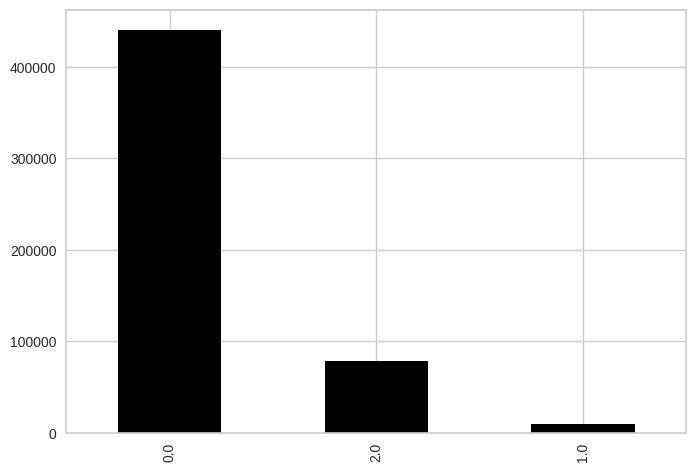

In [6]:
data['Diabetes_012'].value_counts().plot(kind='bar', color='black')

## Selecting Outcomes of Interest

We can see that we have quite an unbalanced dataset. However, because these samples are not evenly distributed in our population, we will leverage different approaches later in our modeling to accommodate for this imbalance.

In [7]:
# select 12328 samples from healthy population
# remove diabetes class entirely

data = data[(data.Diabetes_012 != 2)]

data.groupby(['Diabetes_012']).size()

Diabetes_012
0.0    440607
1.0      9930
dtype: int64

## Continuous Numerical Predictors

We have 1 continuous numerical predictor - BMI. 

### BMI

<AxesSubplot: title={'center': 'BMI'}, ylabel='Frequency'>

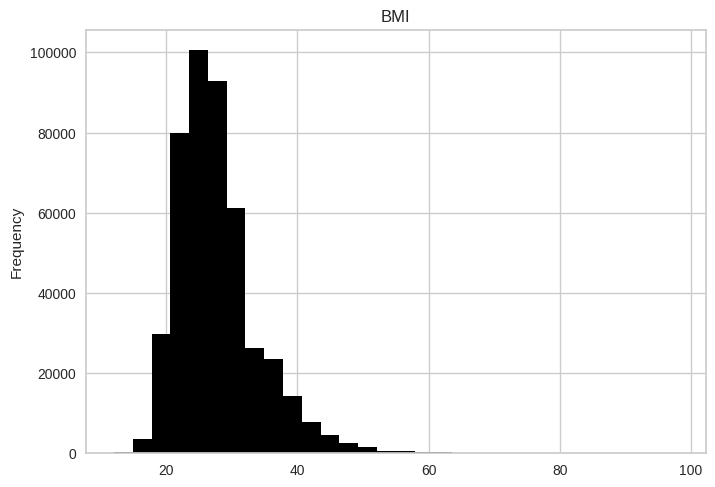

In [8]:
data['BMI'].plot(kind='hist', color='black',bins=30, title='BMI')

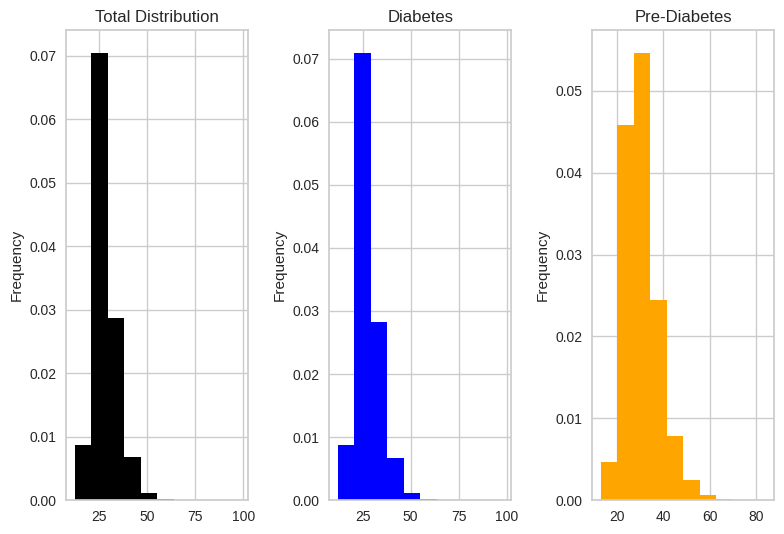

In [9]:
var = 'BMI'

fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
plt.tight_layout()

In [10]:
data[var].groupby(data['Diabetes_012']).describe()

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,,,,,,,,
0.0,440607.0,27.720438,6.351685,12.0,23.0,27.0,31.0,98.0
1.0,9930.0,30.932528,7.253234,13.0,26.0,30.0,35.0,84.0


In [11]:
# One-Way ANOVA - Test of Variance Between Groups
diab = data.query('Diabetes_012 == 0')[var]
prediab = data.query('Diabetes_012 == 1')[var]
import scipy.stats as stats
stats.ttest_ind(diab,prediab,equal_var=False)

Ttest_indResult(statistic=-43.75319382283056, pvalue=0.0)

<AxesSubplot: xlabel='Diabetes_012', ylabel='BMI'>

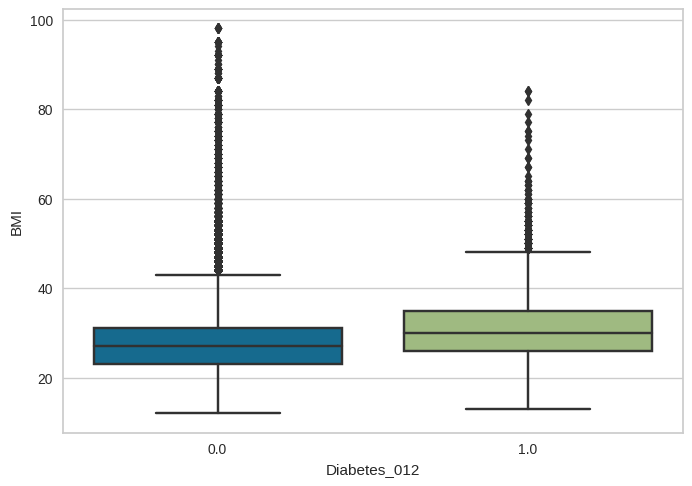

In [12]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

Let's transform this variable - there are quite a few outliers which might make convergence difficult later. We will drop rows where there are outlier BMI values.

below 18.5 - This is described as underweight.

between 18.5 and 24.9 – This is described as the 'healthy range'. 

between 25 and 29.9 – This is described as overweight. 

30 and above - This is described as obesity.

source: https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-loss/body-mass-index-bmi#:~:text=BMI%20ranges&text=between%2018.5%20and%2024.9%20%E2%80%93%20This,is%20described%20as%20severe%20obesity

In [13]:
#data = data.loc[
#    ((data['Diabetes_012'] == 0) & (data['BMI'] >= 23) & (data['BMI'] <= 31)) 
#    |
#    ((data['Diabetes_012'] == 1) & (data['BMI'] >= 26) & (data['BMI'] <= 35))]

In [14]:
data['BMI'].mask(data['BMI'] < 18.5, 0, inplace=True)
data['BMI'].mask((data['BMI'] >= 18.5) & (data['BMI'] <= 24.9), 1, inplace=True)
data['BMI'].mask((data['BMI'] >= 25) & (data['BMI'] <= 29.9), 2, inplace=True)
data['BMI'].mask((data['BMI'] >= 30) & (data['BMI'] <= 34.9), 3, inplace=True)
data['BMI'].mask((data['BMI'] >= 35) & (data['BMI'] <= 39.9), 4, inplace=True)
data['BMI'].mask((data['BMI'] >= 40), 5, inplace=True)

Text(0.5, 1.0, 'Pre-Diabetes')

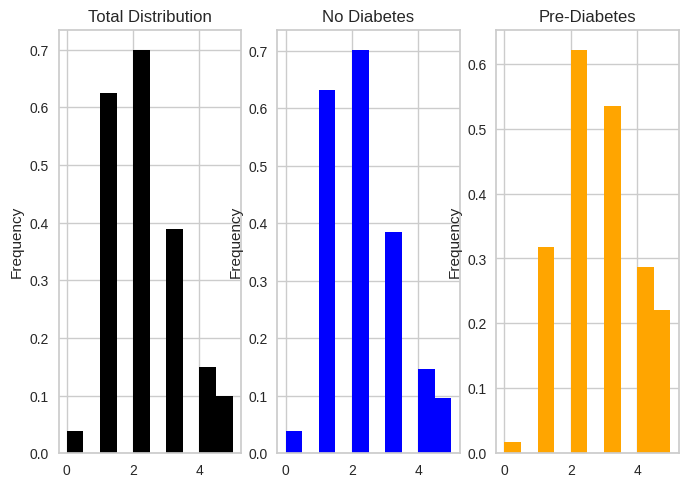

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")


## Categorical Predictors
The rest of our predictors are categorical or binary. 
This requires a different approach than what we can do with a continous valued predictor.


HighBP

HighChol

CholCheck

BMI

Smoker

Stroke

HeartDiseaseorAttack

PhysActivity

Fruits

Veggies

HvyAlcoholConsump

AnyHealthcare

NoDocbcCost

GenHlth

DiffWalk

Sex 

Age    

Education

Income                  


In [16]:
def var_hist(var, data,fig,w,h):
    
    plt.tight_layout()
    gs = fig.add_gridspec(5,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    ax7 = fig.add_subplot(gs[4, 0])
    ax8 = fig.add_subplot(gs[4, 1])
    plt.tight_layout()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.suptitle(var, fontsize=14)
    data[var].plot(ax=ax1,kind='hist',color='black', density=True).set_title("Total Distribution")
    data.query('Diabetes_012 == 0')[var].plot(ax=ax2,kind='hist',color='blue', density=True).set_title("No Diabetes")
    data.query('Diabetes_012 == 1')[var].plot(ax=ax3,kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
    desc = data[var].groupby(data['Diabetes_012']).describe()
    desc.insert(0, 'Class', desc.index)
    table = desc 
    cell_text = []
    for row in range(len(table)):
        cell_text.append(round(table.iloc[row],2))
    table = ax5.table(cellText=cell_text, colLabels=table.columns, loc=ax5)
    ax5.axis('off')
    table.set_fontsize(10)
    ax5.set_title(var + " - descriptive statistics")
    plt.tight_layout()
    crosstab = pd.crosstab(data[var],data['Diabetes_012'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    ct_data = {'Chi-square: ':  [chi2],
            'p-value: ': [p],
            'DOF: ': [dof]}
    df = pd.DataFrame(ct_data)
    cell_text_chi = []
    for row in range(len(df)):
        cell_text_chi.append(df.iloc[row])
    table_chi = ax6.table(cellText=cell_text_chi,colLabels=df.columns, loc=ax6)
    ax6.axis('off')
    table_chi.set_fontsize(10)
    ax6.set_title(var + " - Chi Square Test")
    plt.tight_layout()
    act = pd.DataFrame(crosstab)
    act_cell_text = []
    for row in range(len(act)):
        act_cell_text.append(act.iloc[row])
    table_act = ax7.table(cellText=act_cell_text,colLabels=act.columns, loc=ax7)
    ax7.axis('tight')
    ax7.axis('off')
    table_act.set_fontsize(10)
    ax7.set_title("Chi Square - Actual Frequencies")
    plt.tight_layout()
    exp = pd.DataFrame(expected)
    exp_cell_text = []
    for row in range(len(exp)):
        exp_cell_text.append(exp.iloc[row])
    table_exp = ax8.table(cellText=exp_cell_text,colLabels=exp.columns, loc=ax8)
    ax8.axis('off')
    table_exp.set_fontsize(10)
    ax8.set_title("Chi Square - Expected Frequencies")

In [17]:
from sklearn.feature_selection import chi2

X = data.drop('Diabetes_012',axis=1)
y = data['Diabetes_012']

chi_scores = chi2(X,y)
chi_scores

(array([1.52424899e+03, 7.15712358e+01, 3.69061192e+02, 1.00704337e+02,
        3.32371167e-01, 1.55182398e+02, 1.30780433e+03, 5.64873829e-02,
        1.30711723e+02, 6.23090311e-05, 3.03521596e+03, 1.66148228e+02,
        1.19280324e+03, 7.99186687e+01, 1.95130454e+02, 4.77966972e+02,
        1.74672253e+03]),
 array([0.00000000e+000, 2.67426877e-017, 2.99641757e-082, 1.06791509e-023,
        5.64266184e-001, 1.27742174e-035, 2.27632867e-286, 8.12136476e-001,
        2.86306707e-030, 9.93701878e-001, 0.00000000e+000, 5.13437017e-038,
        2.23541987e-261, 3.90142874e-019, 2.41290325e-044, 5.91735951e-106,
        0.00000000e+000]))

In [18]:
p_values = pd.DataFrame(chi_scores[1],index = X.columns)
print(p_values)
print("p-value greater than 0.05:")
for p in p_values.index:
    val = p_values.loc[p]
    if val.loc[0] > 0.05:
        print(val.name)

                           0
BMI             0.000000e+00
Smoker          2.674269e-17
Stroke          2.996418e-82
PhysActivity    1.067915e-23
AnyHealthcare   5.642662e-01
NoDocbcCost     1.277422e-35
GenHlth        2.276329e-286
MentHlth        8.121365e-01
PhysHlth        2.863067e-30
Sex             9.937019e-01
Age             0.000000e+00
Education       5.134370e-38
Income         2.235420e-261
Marital         3.901429e-19
PoorHlth        2.412903e-44
HeartAttack    5.917360e-106
HighBP          0.000000e+00
p-value greater than 0.05:
AnyHealthcare
MentHlth
Sex


In [19]:
data = data.drop(columns=['AnyHealthcare','MentHlth','Sex'],axis=1)
var_list = list(data.drop('Diabetes_012', axis=1).columns)
var_idx = -1

### BMI

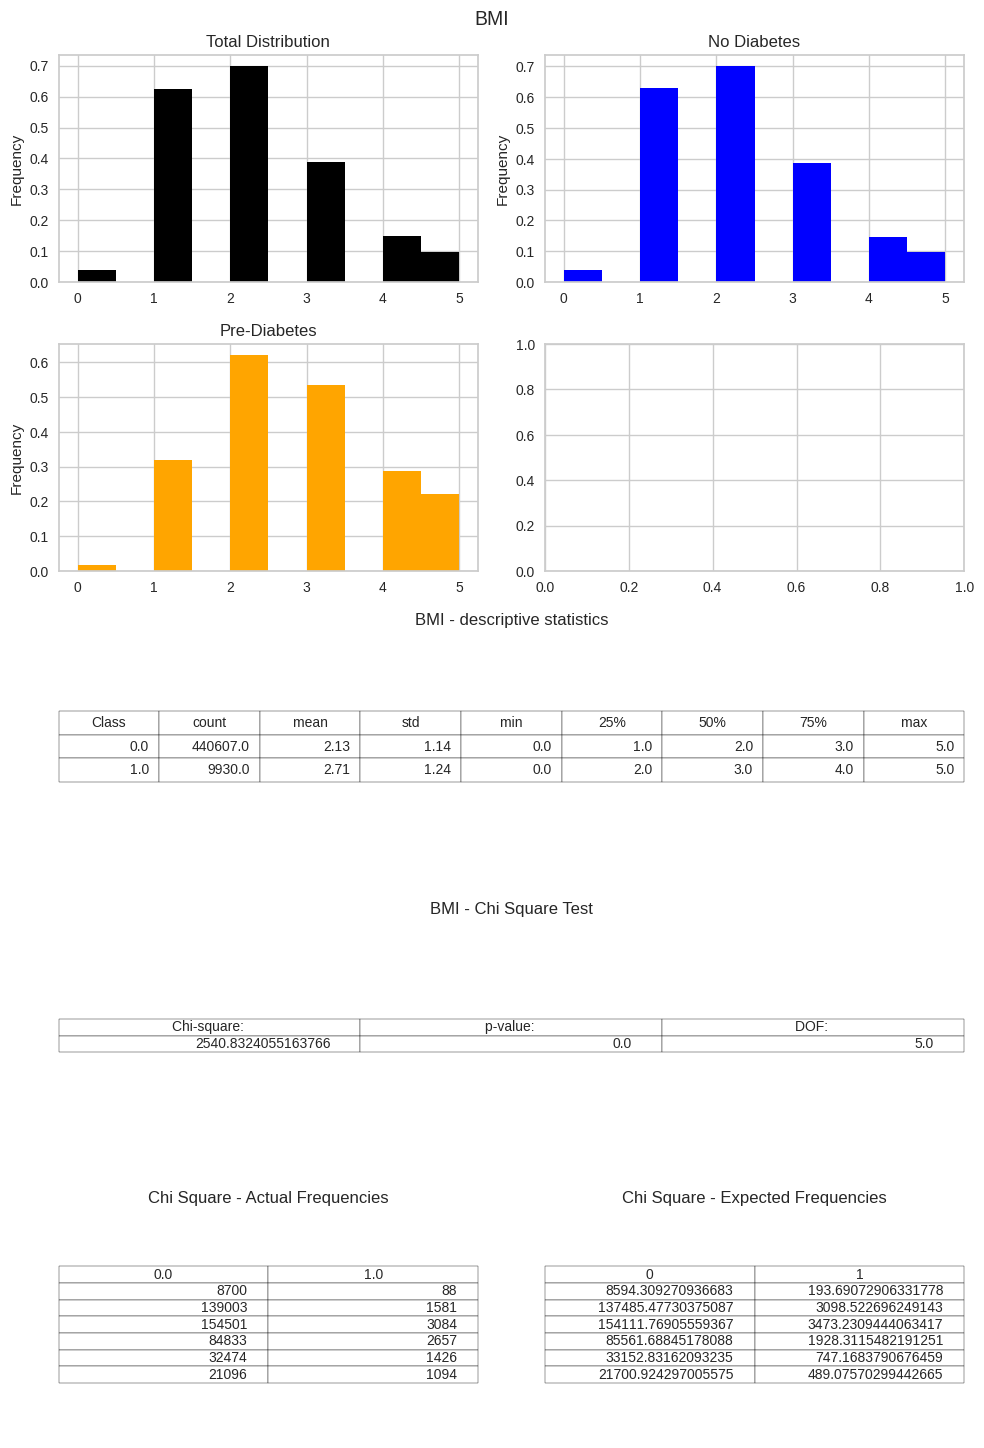

In [20]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Smoker

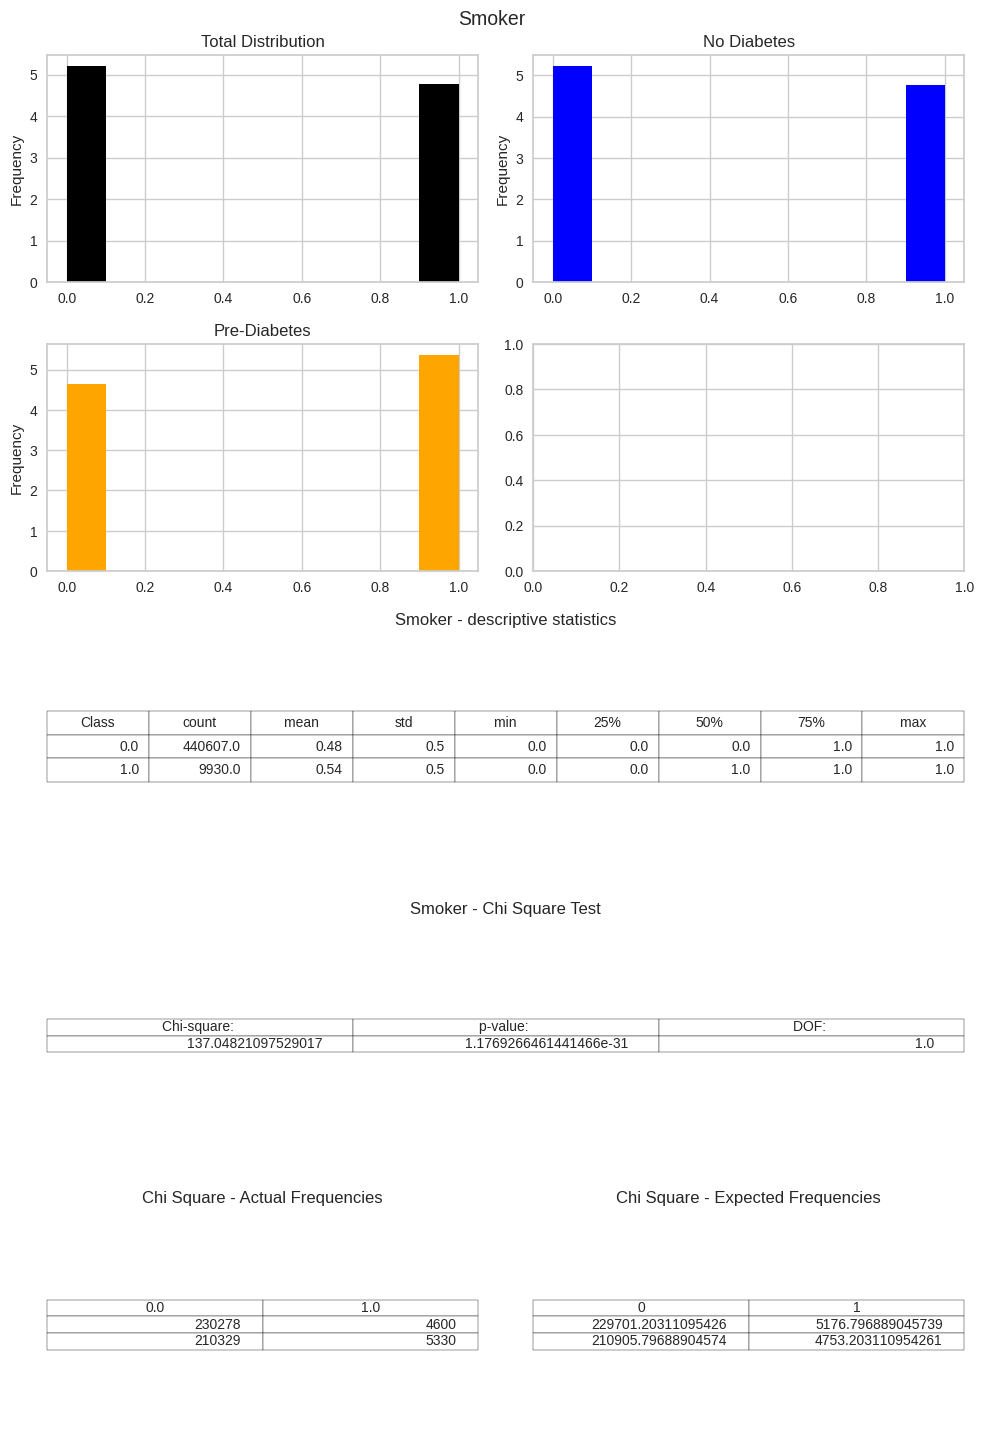

In [21]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Stroke

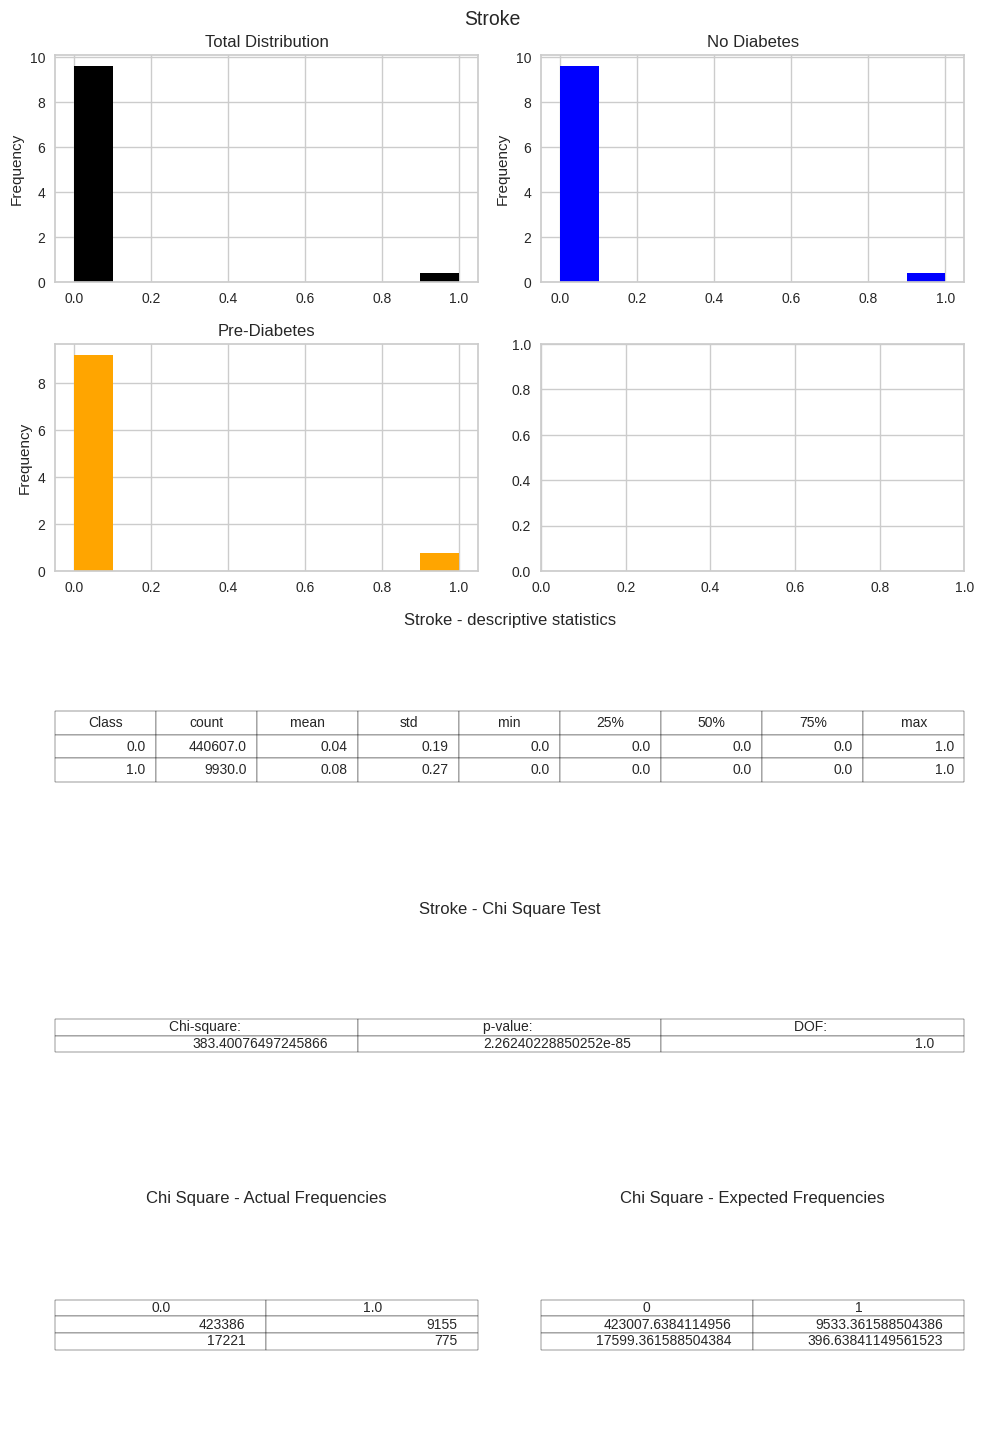

In [22]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Activity

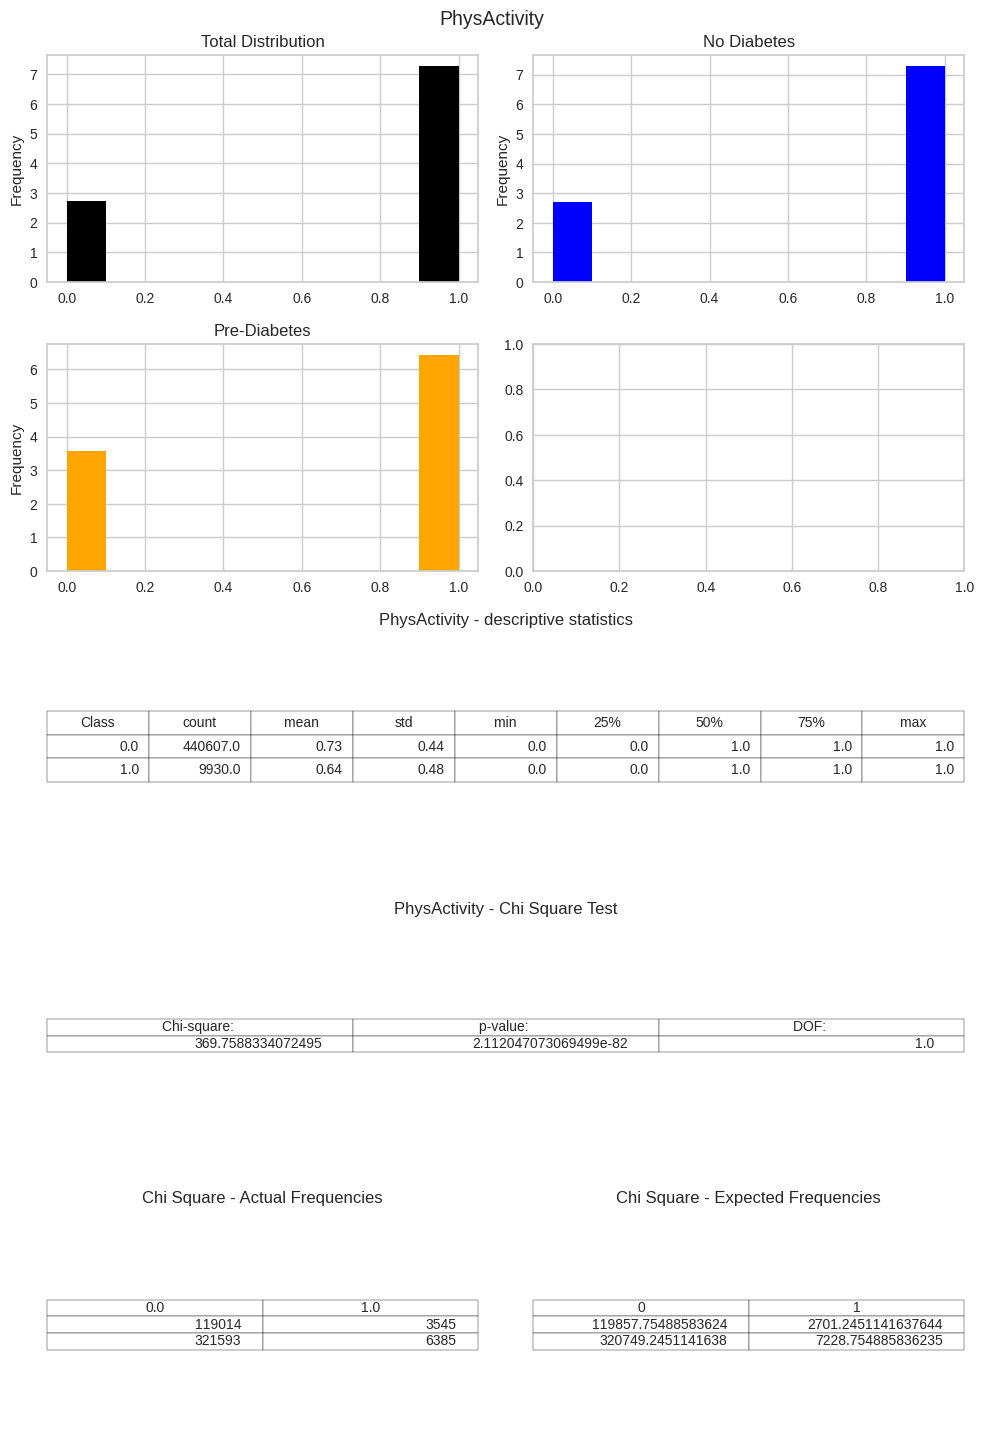

In [23]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### No Doctor Because of Cost

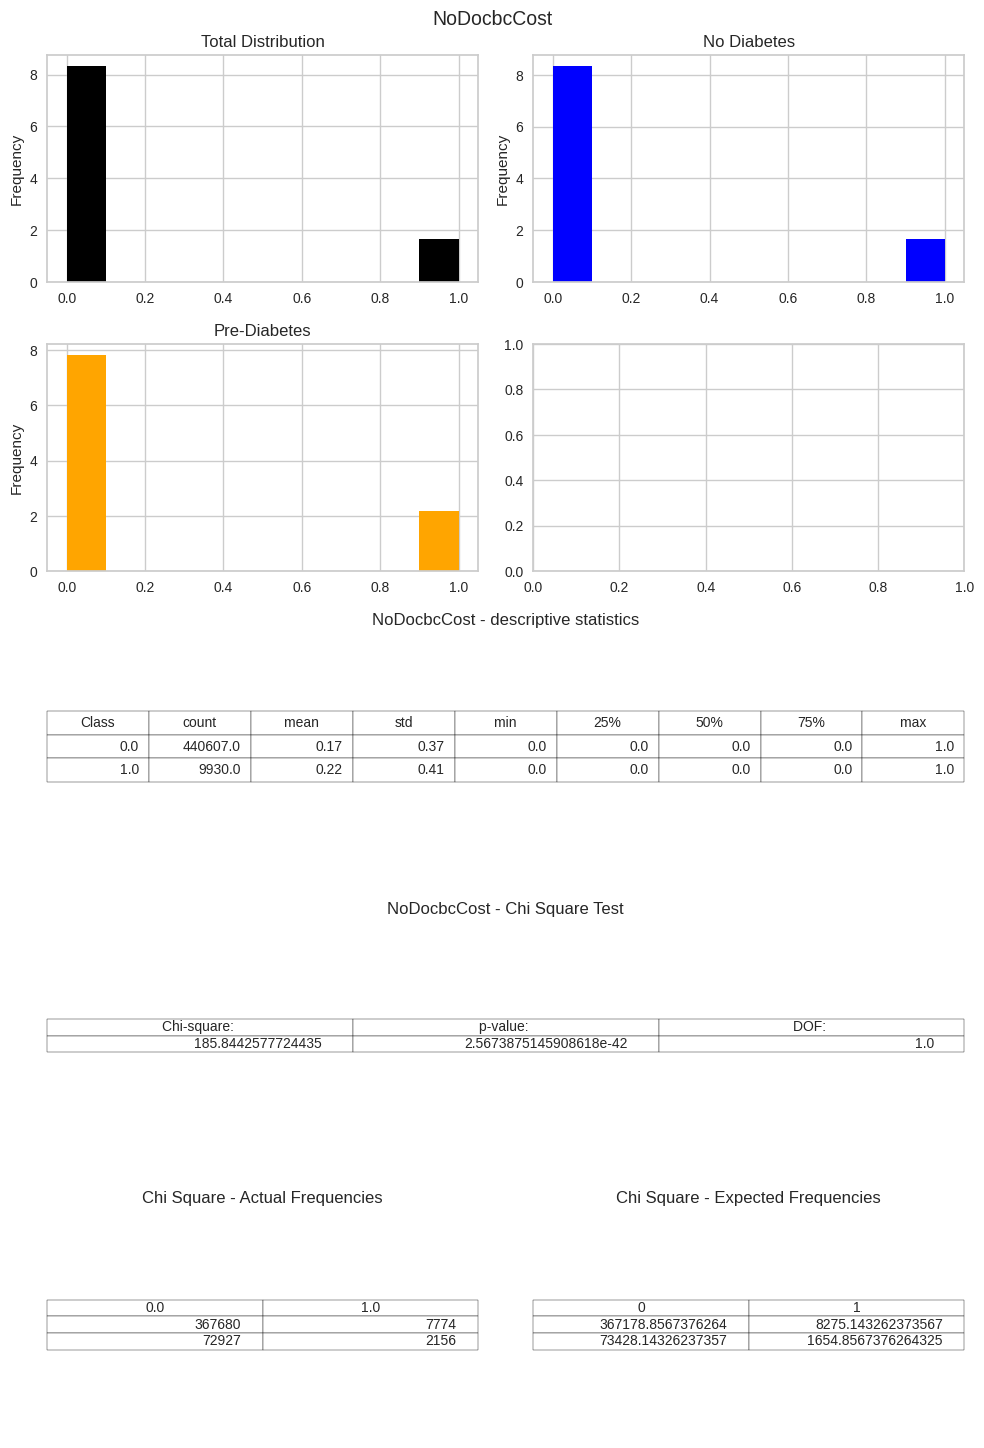

In [24]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### General Health

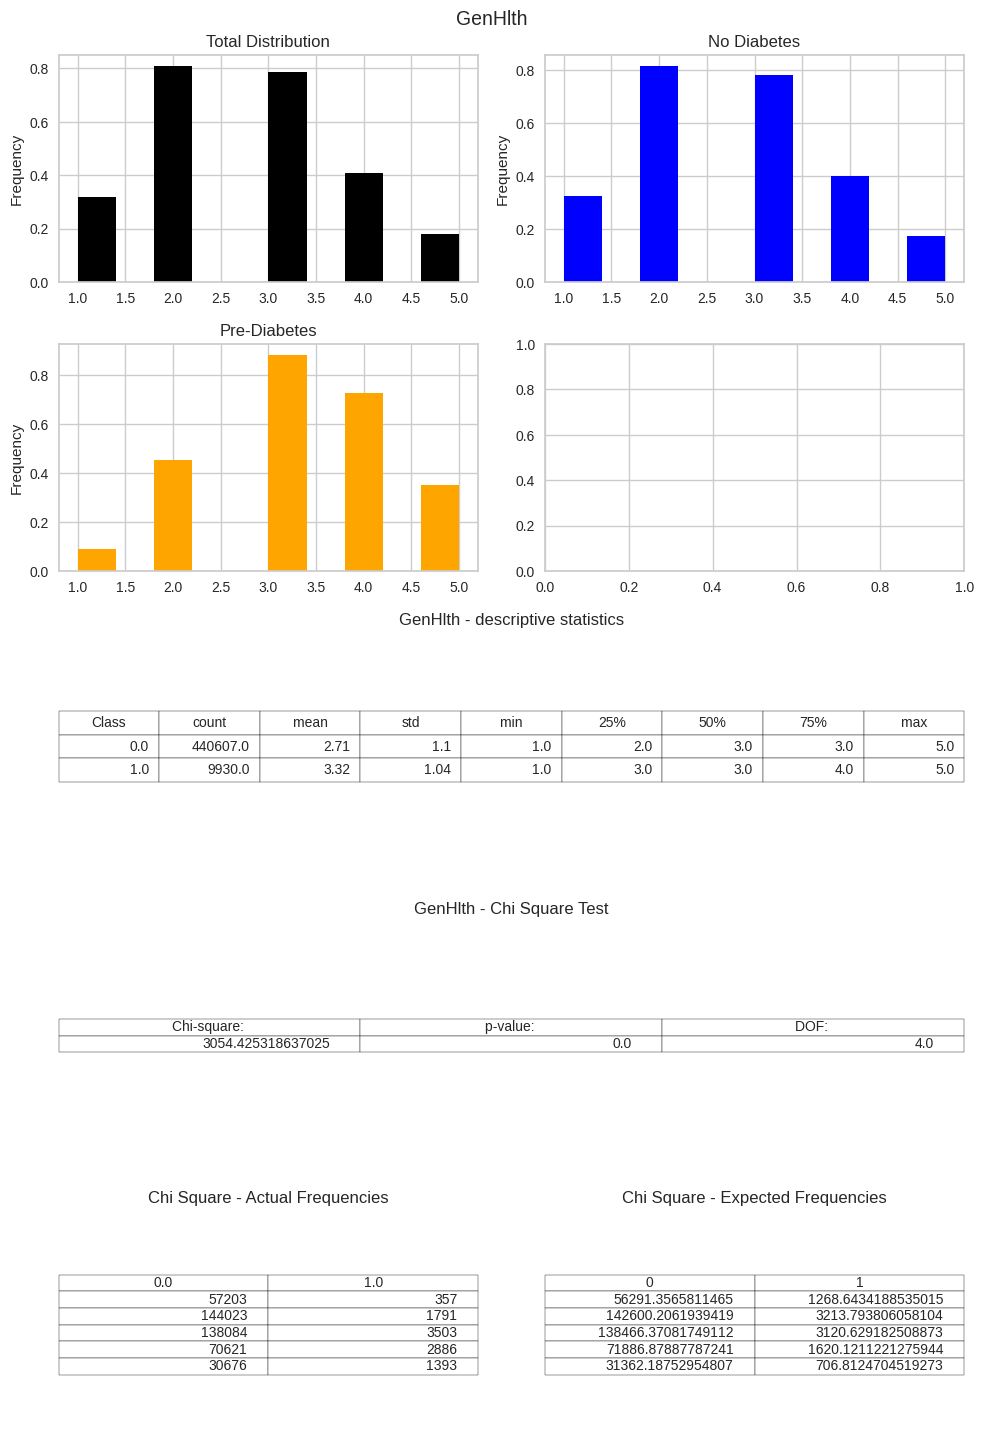

In [25]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Health

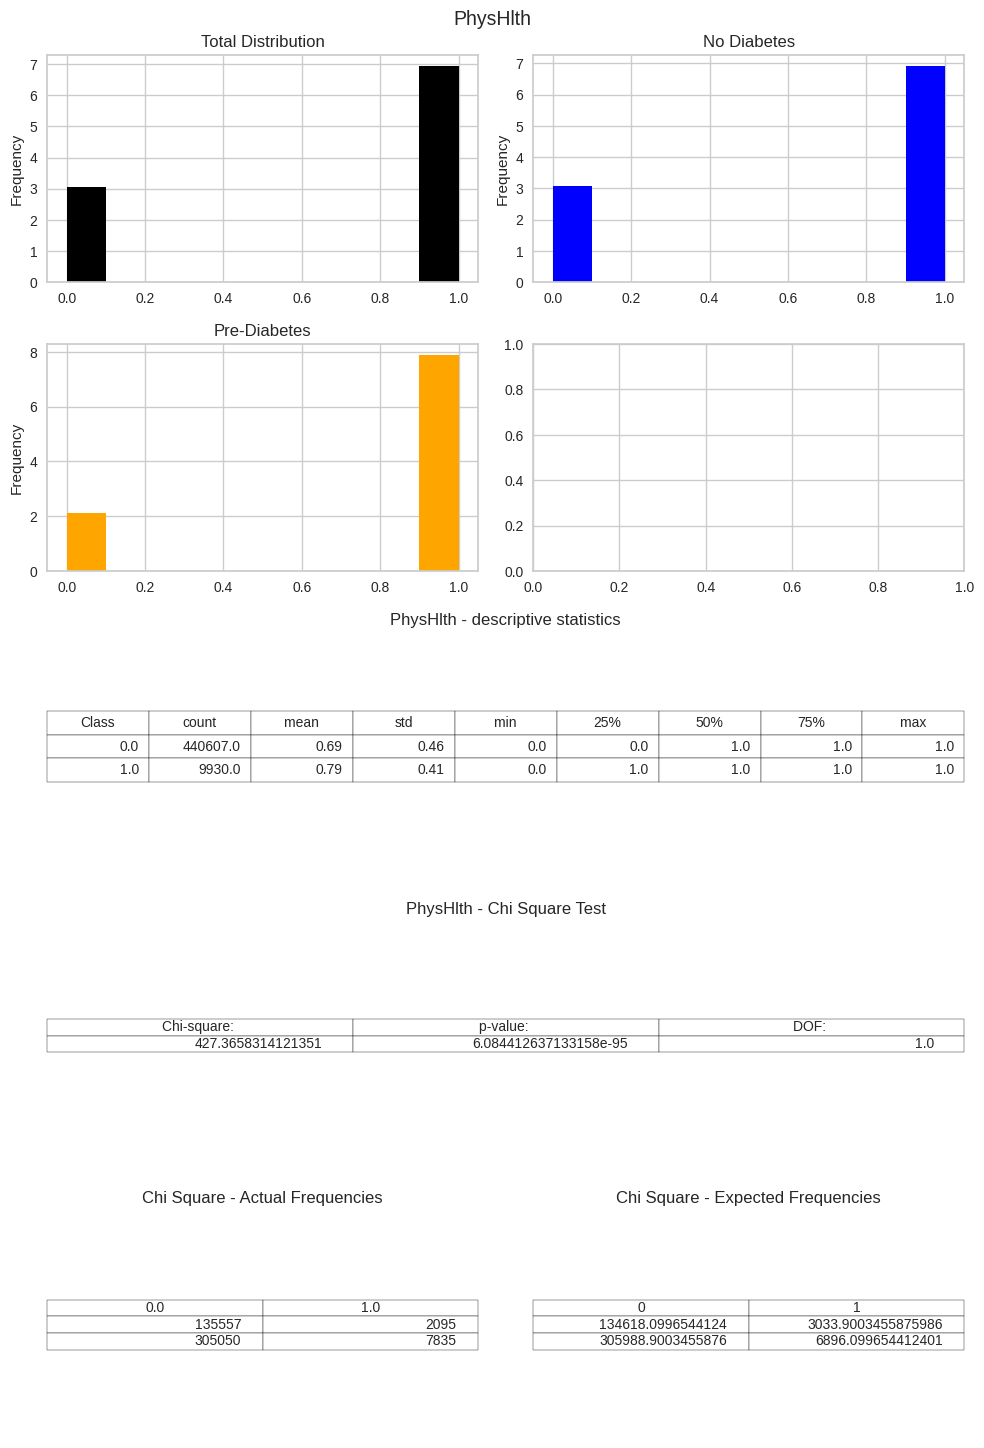

In [26]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Age

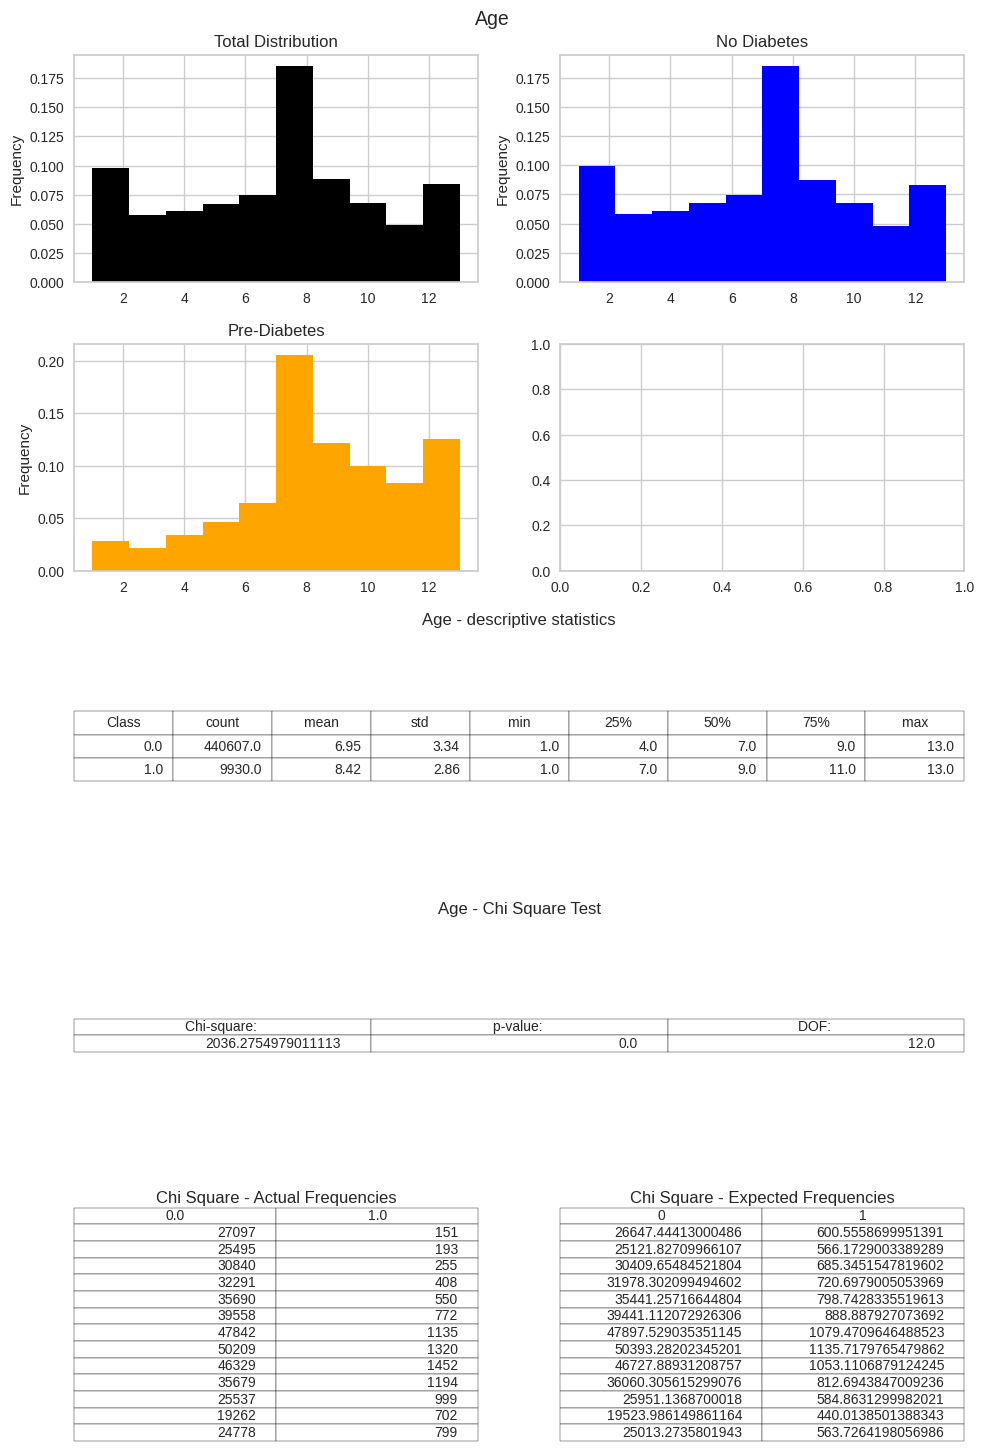

In [27]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Education

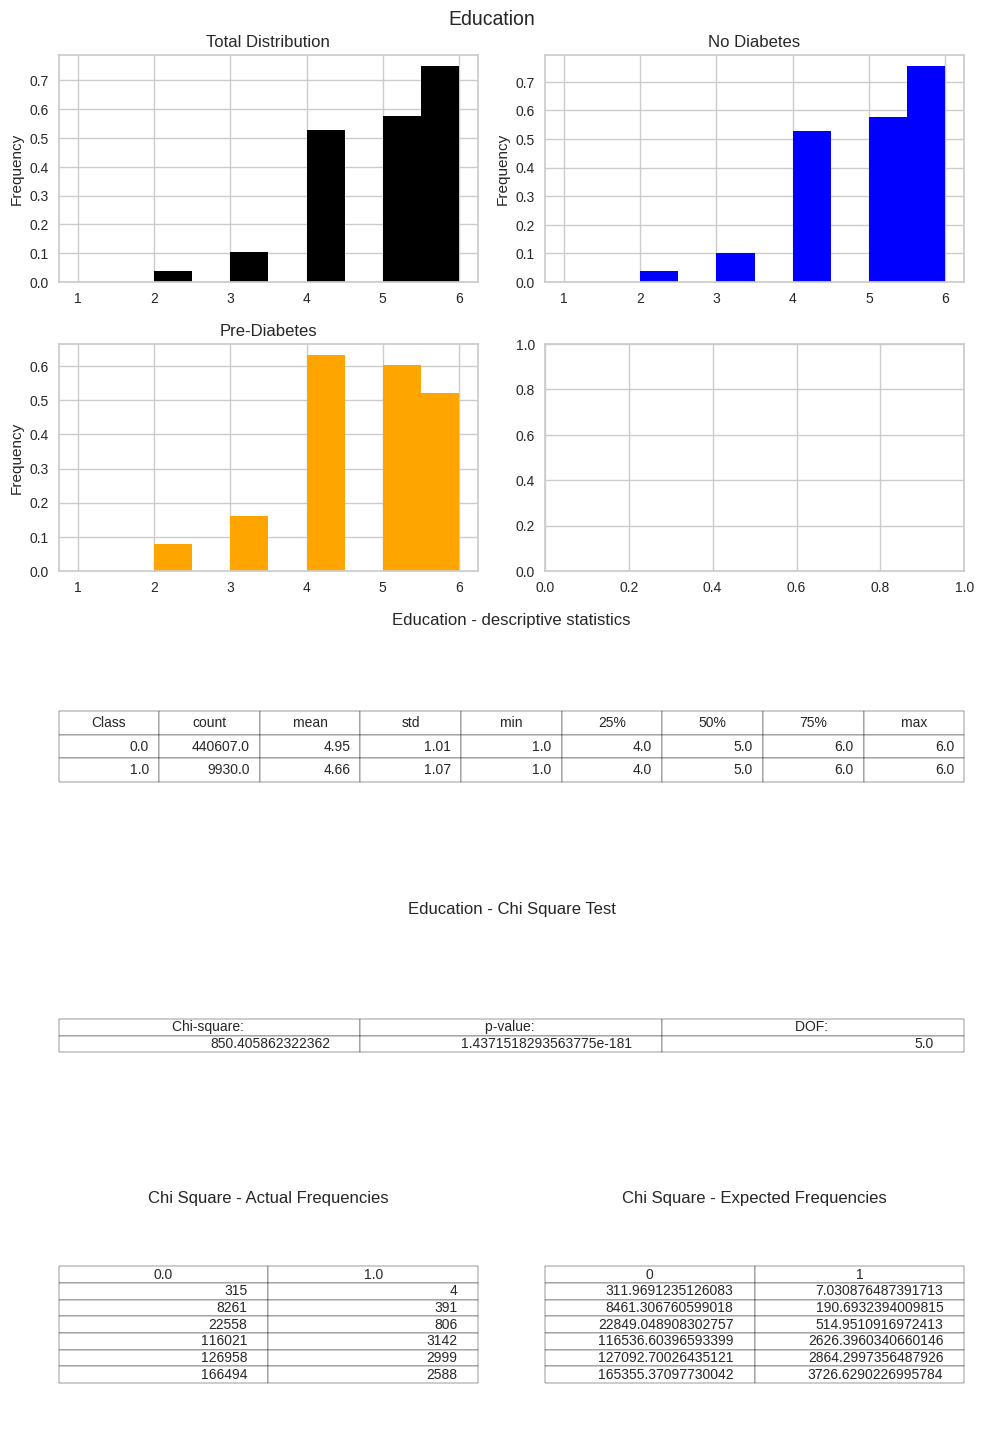

In [28]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Income

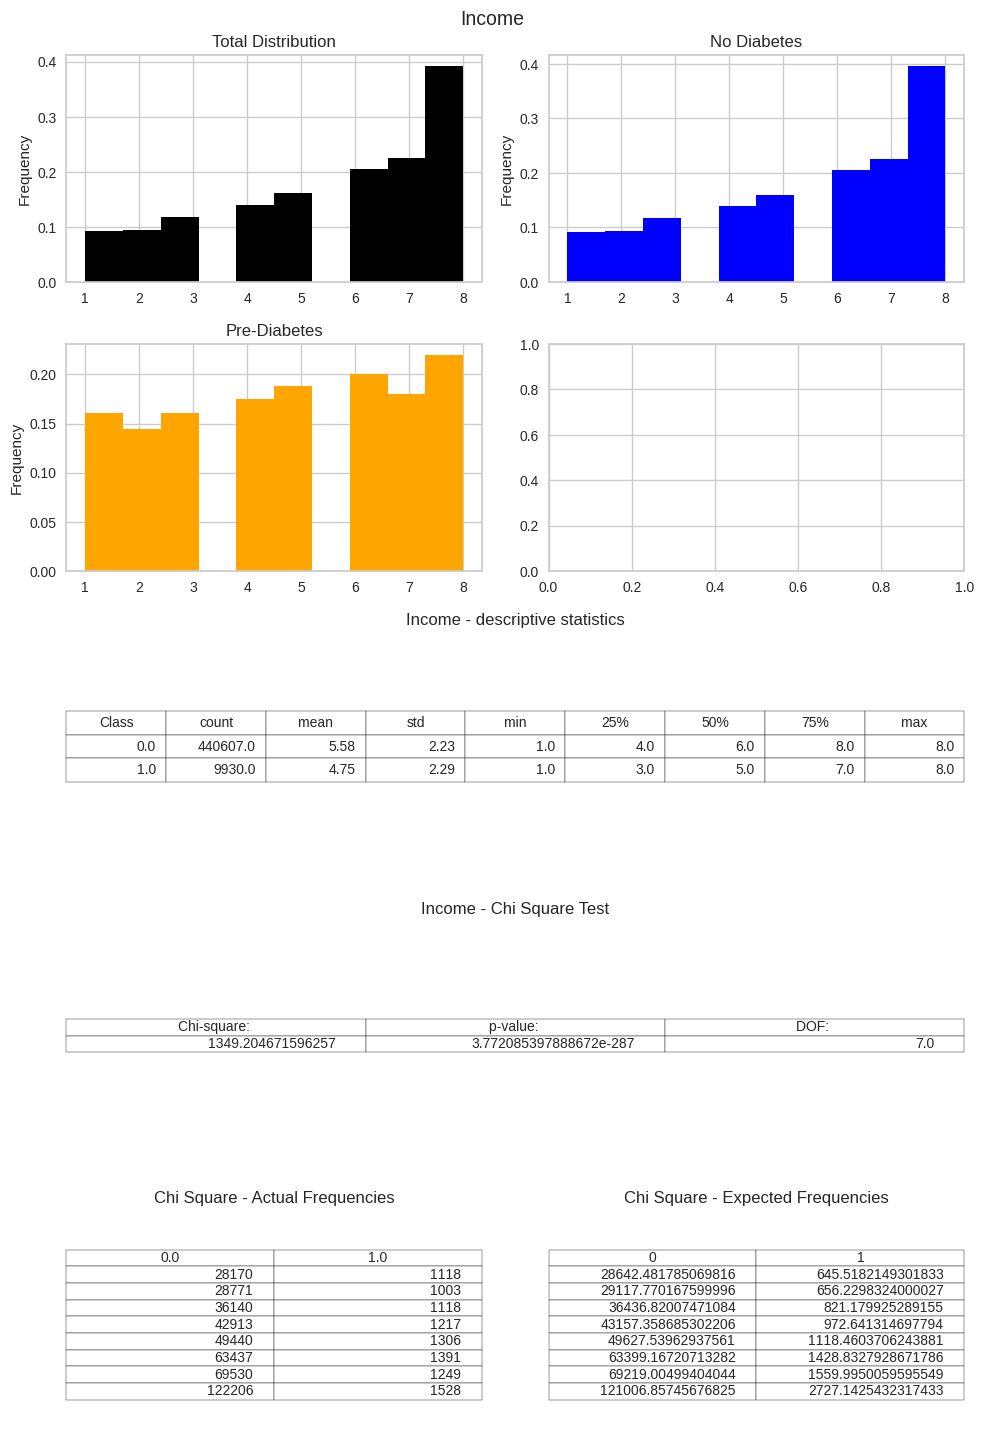

In [29]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Marital Status

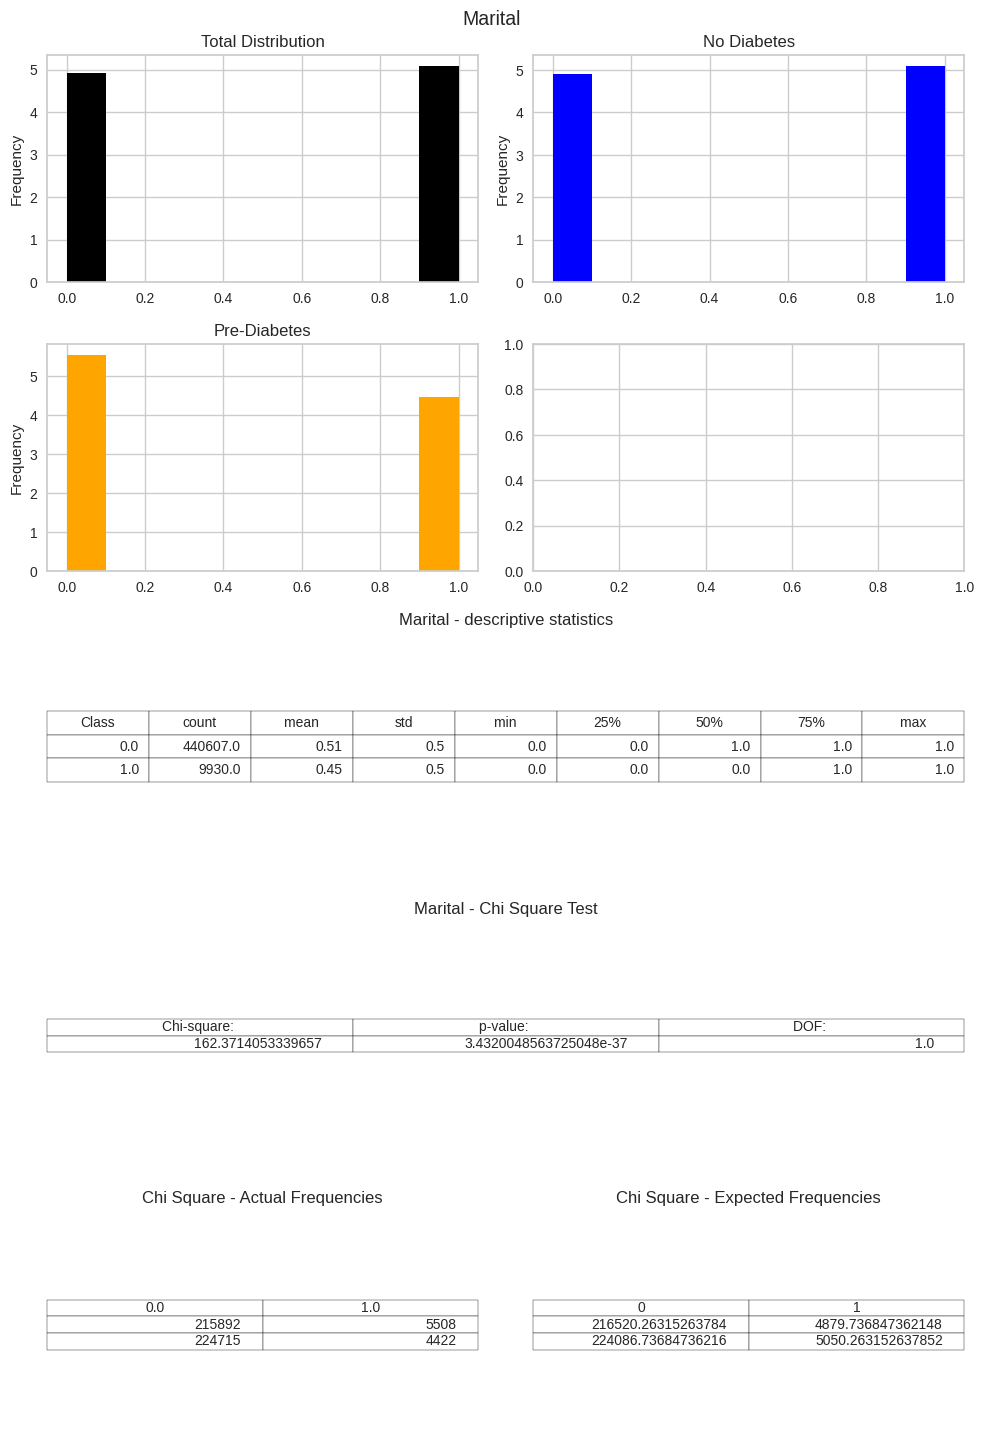

In [30]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Poor Health

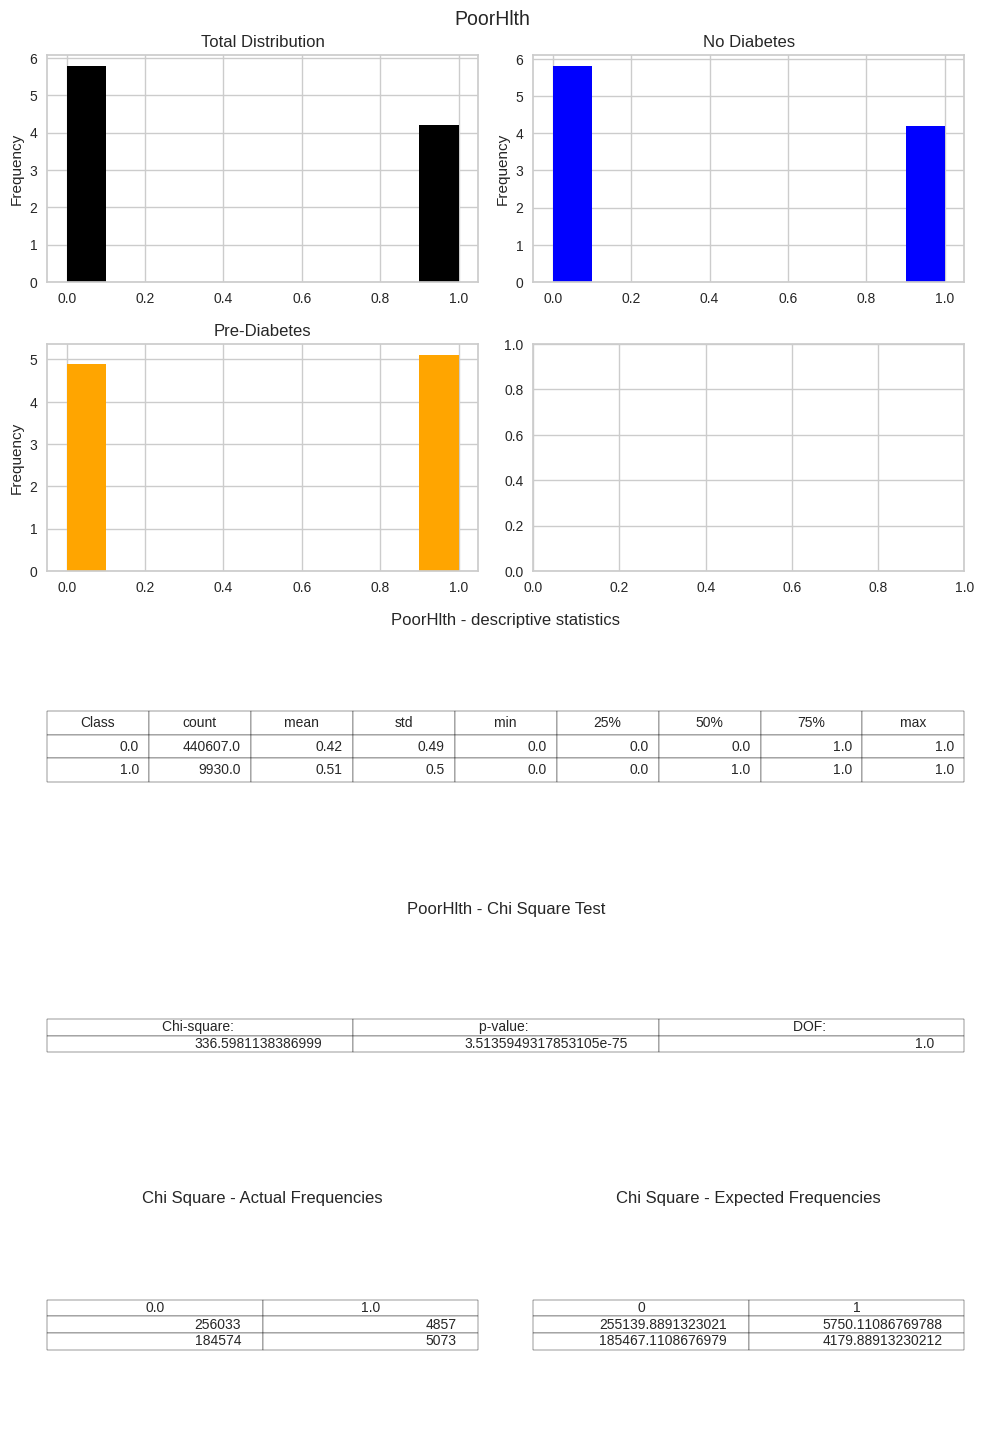

In [31]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heart Attack

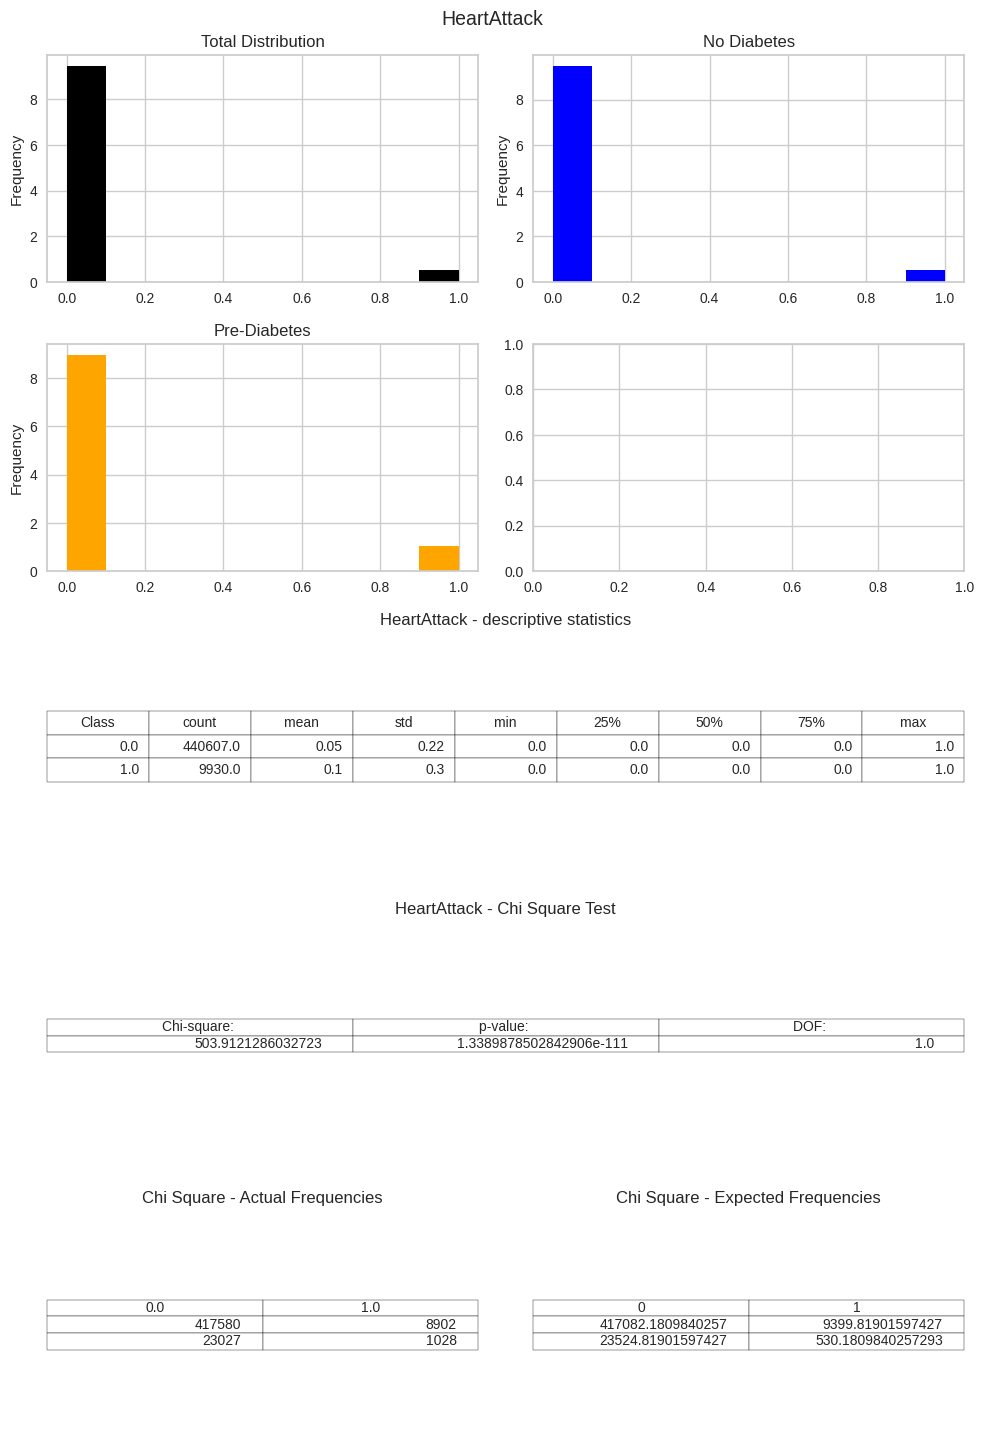

In [32]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### High Blood Pressure

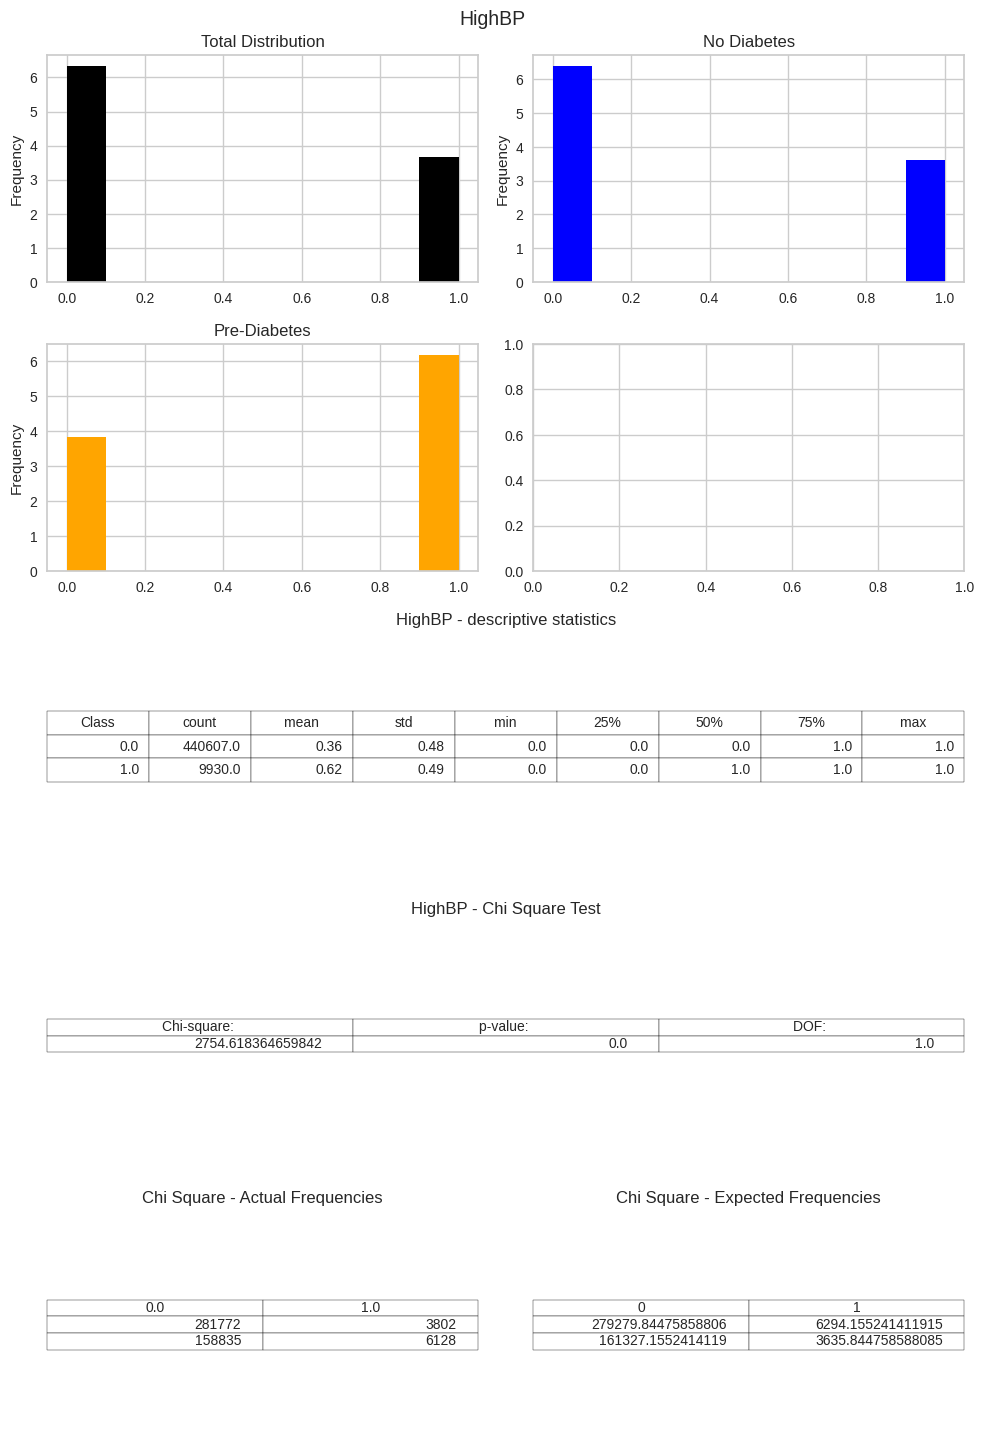

In [33]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

## Collinearity & Variance

When using regression techniques, we make the statistical assumption that are predictors are independent, or not related. Thus, it is important that we drop any strongly intercorrelated features from our analysis. 

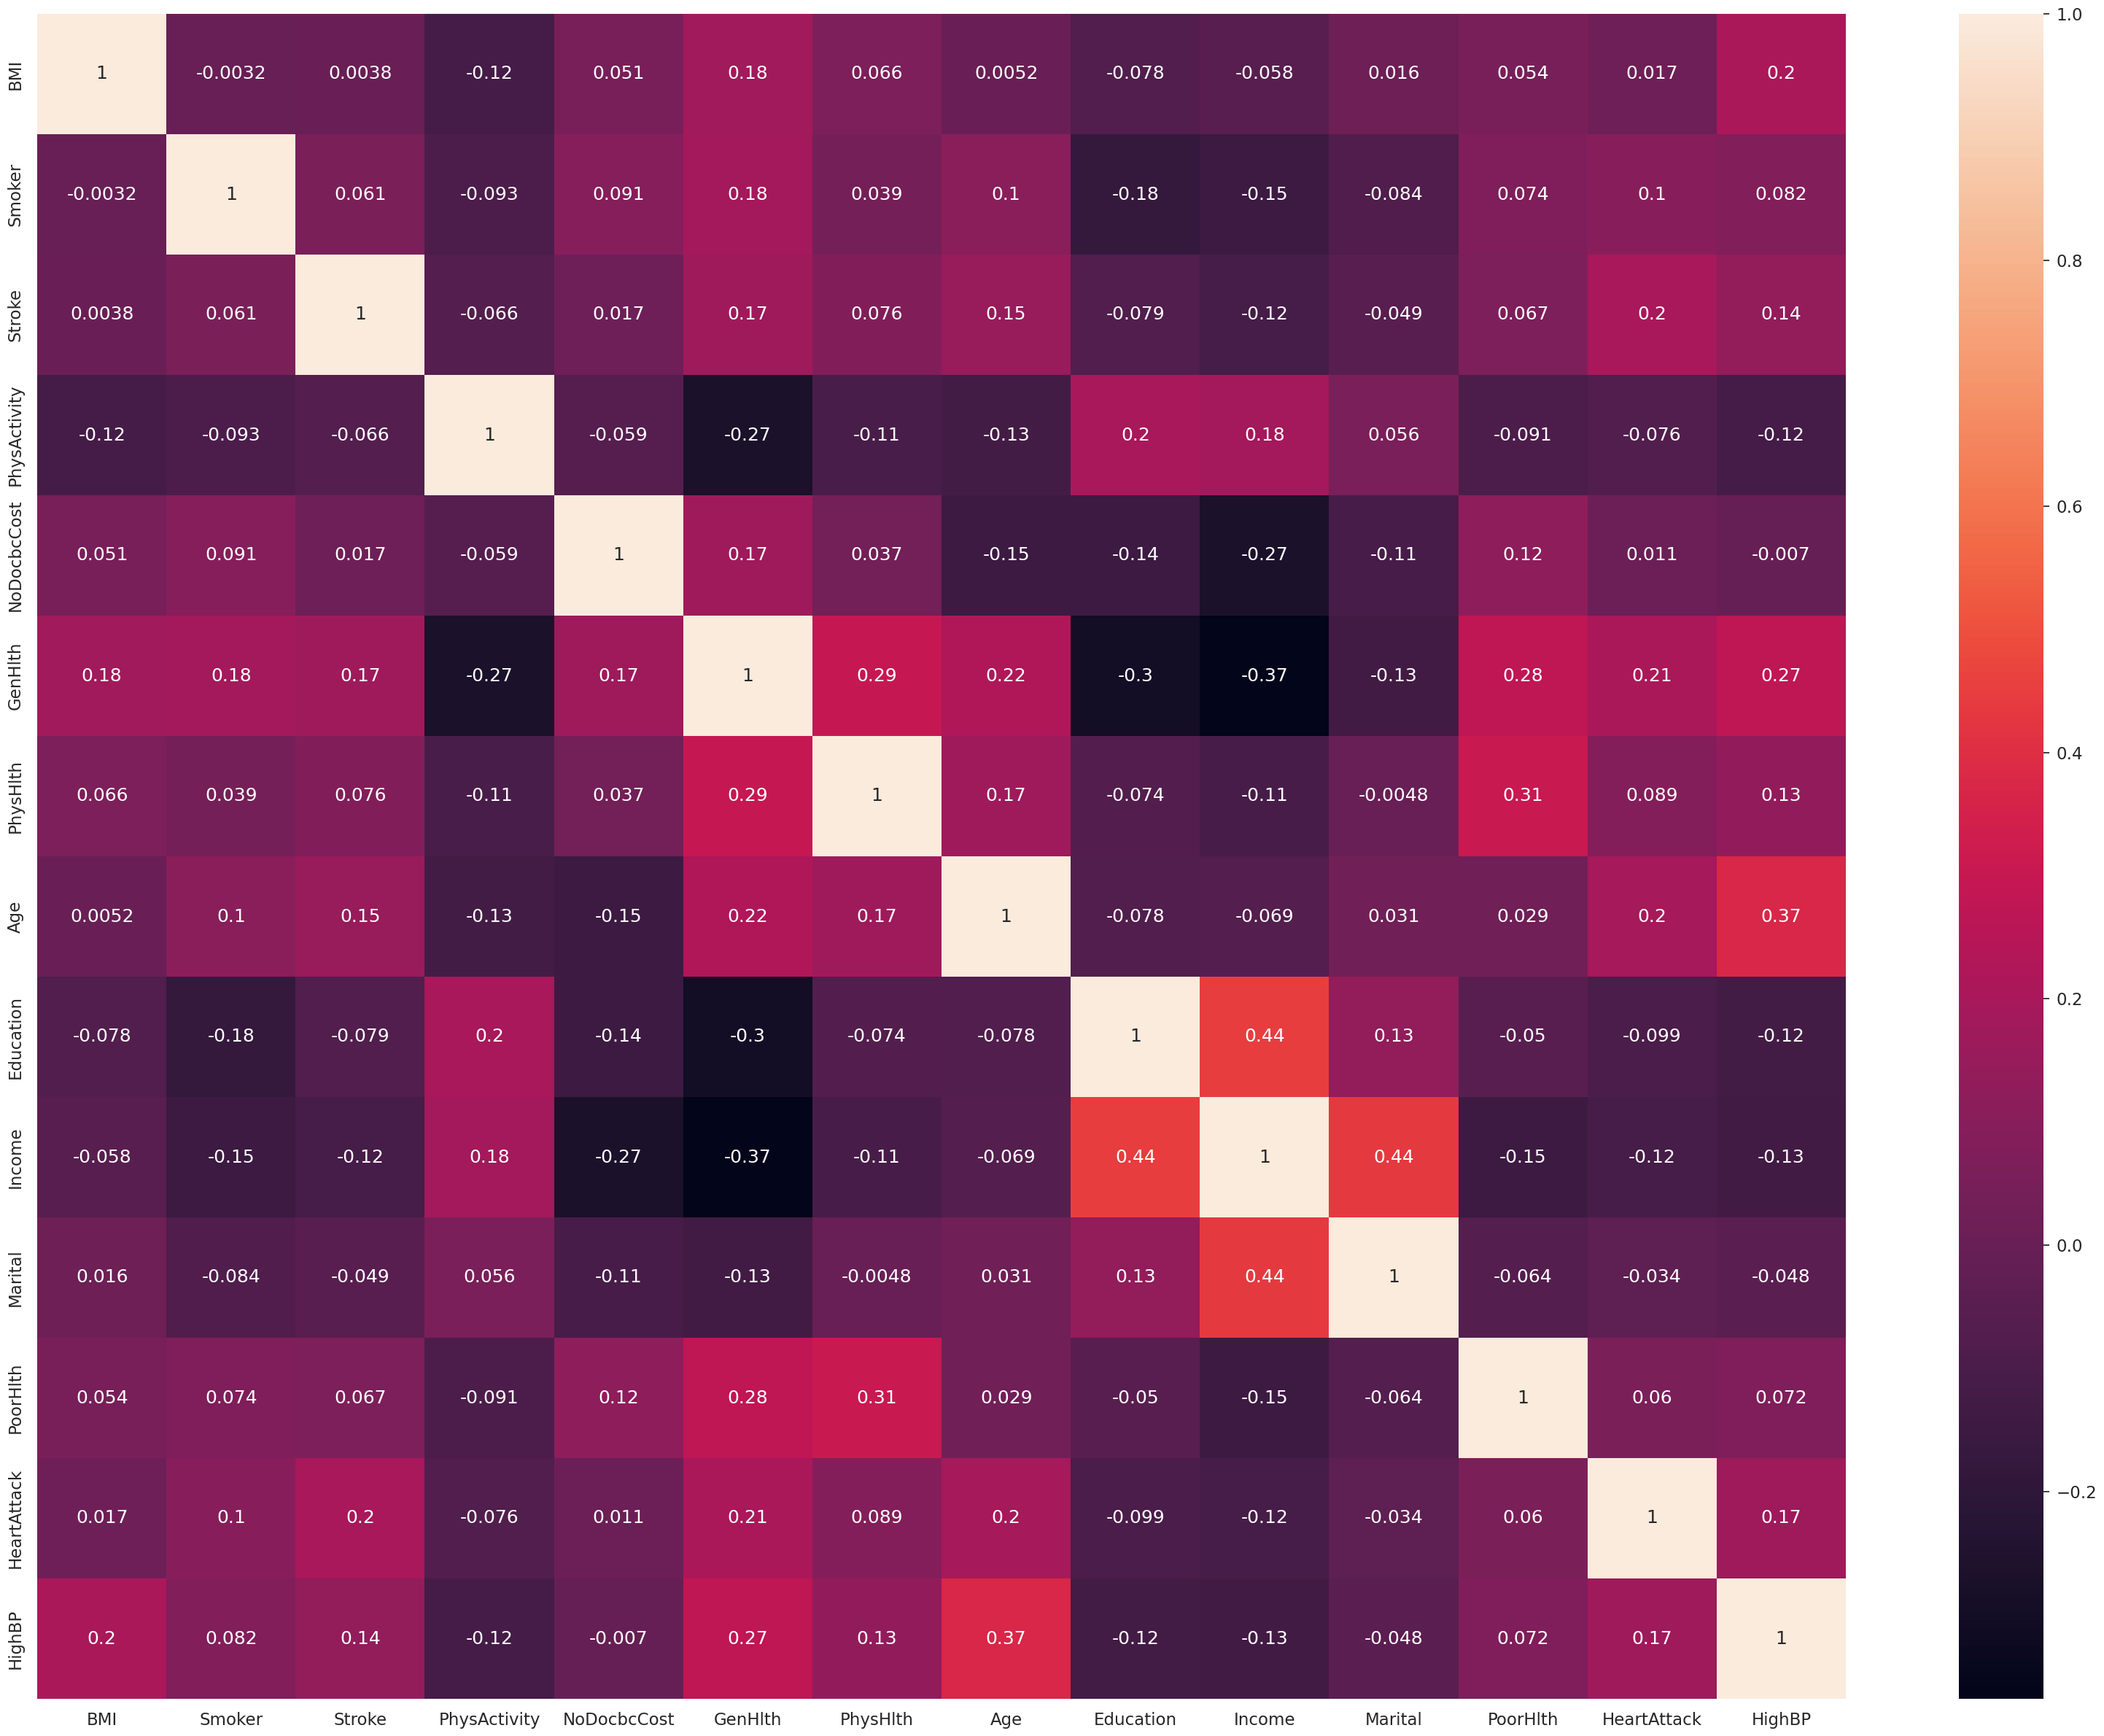

In [34]:
data_full = data
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are actually not many values that are strongly intercorrelated. Usually a strong correlation is considered to be 0.70 or greater. However, there are some variables that are moderately intercorrelated.

In [35]:
def vif(data_corr):
    drop_cols = []
    vif_flag = False
    while(vif_flag == False):
        vif = pd.DataFrame()
        vif["features"] = data_corr.columns
        vif["vif_factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
        vif = vif.sort_values(by=['vif_factor'], ascending=False)
        top_vif = vif.iloc[0]
        top_vif_name = top_vif['features']
        if(top_vif.loc['vif_factor'] > 5):
            drop_cols.append(top_vif_name)
            print(top_vif_name, ':', top_vif['vif_factor'])
            data_corr = data_corr.drop([top_vif_name],axis=1)
            continue
        else:
            vif_flag = True
            return vif, drop_cols

We will drop variables one by one, starting with the highest VIF scores.

In [36]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif, drop_cols = vif(data_corr)

vif

Education : 19.272341366870755
GenHlth : 8.194510464527859
Income : 7.014545583544862
Age : 5.14532428342209


,features,vif_factor
0,BMI,3.531453
5,PhysHlth,3.231879
3,PhysActivity,2.544102
7,PoorHlth,1.927223
6,Marital,1.914890
1,Smoker,1.815948
9,HighBP,1.737924
4,NoDocbcCost,1.230540
8,HeartAttack,1.137090
2,Stroke,1.104575


In [37]:
data = data.drop(columns=drop_cols)

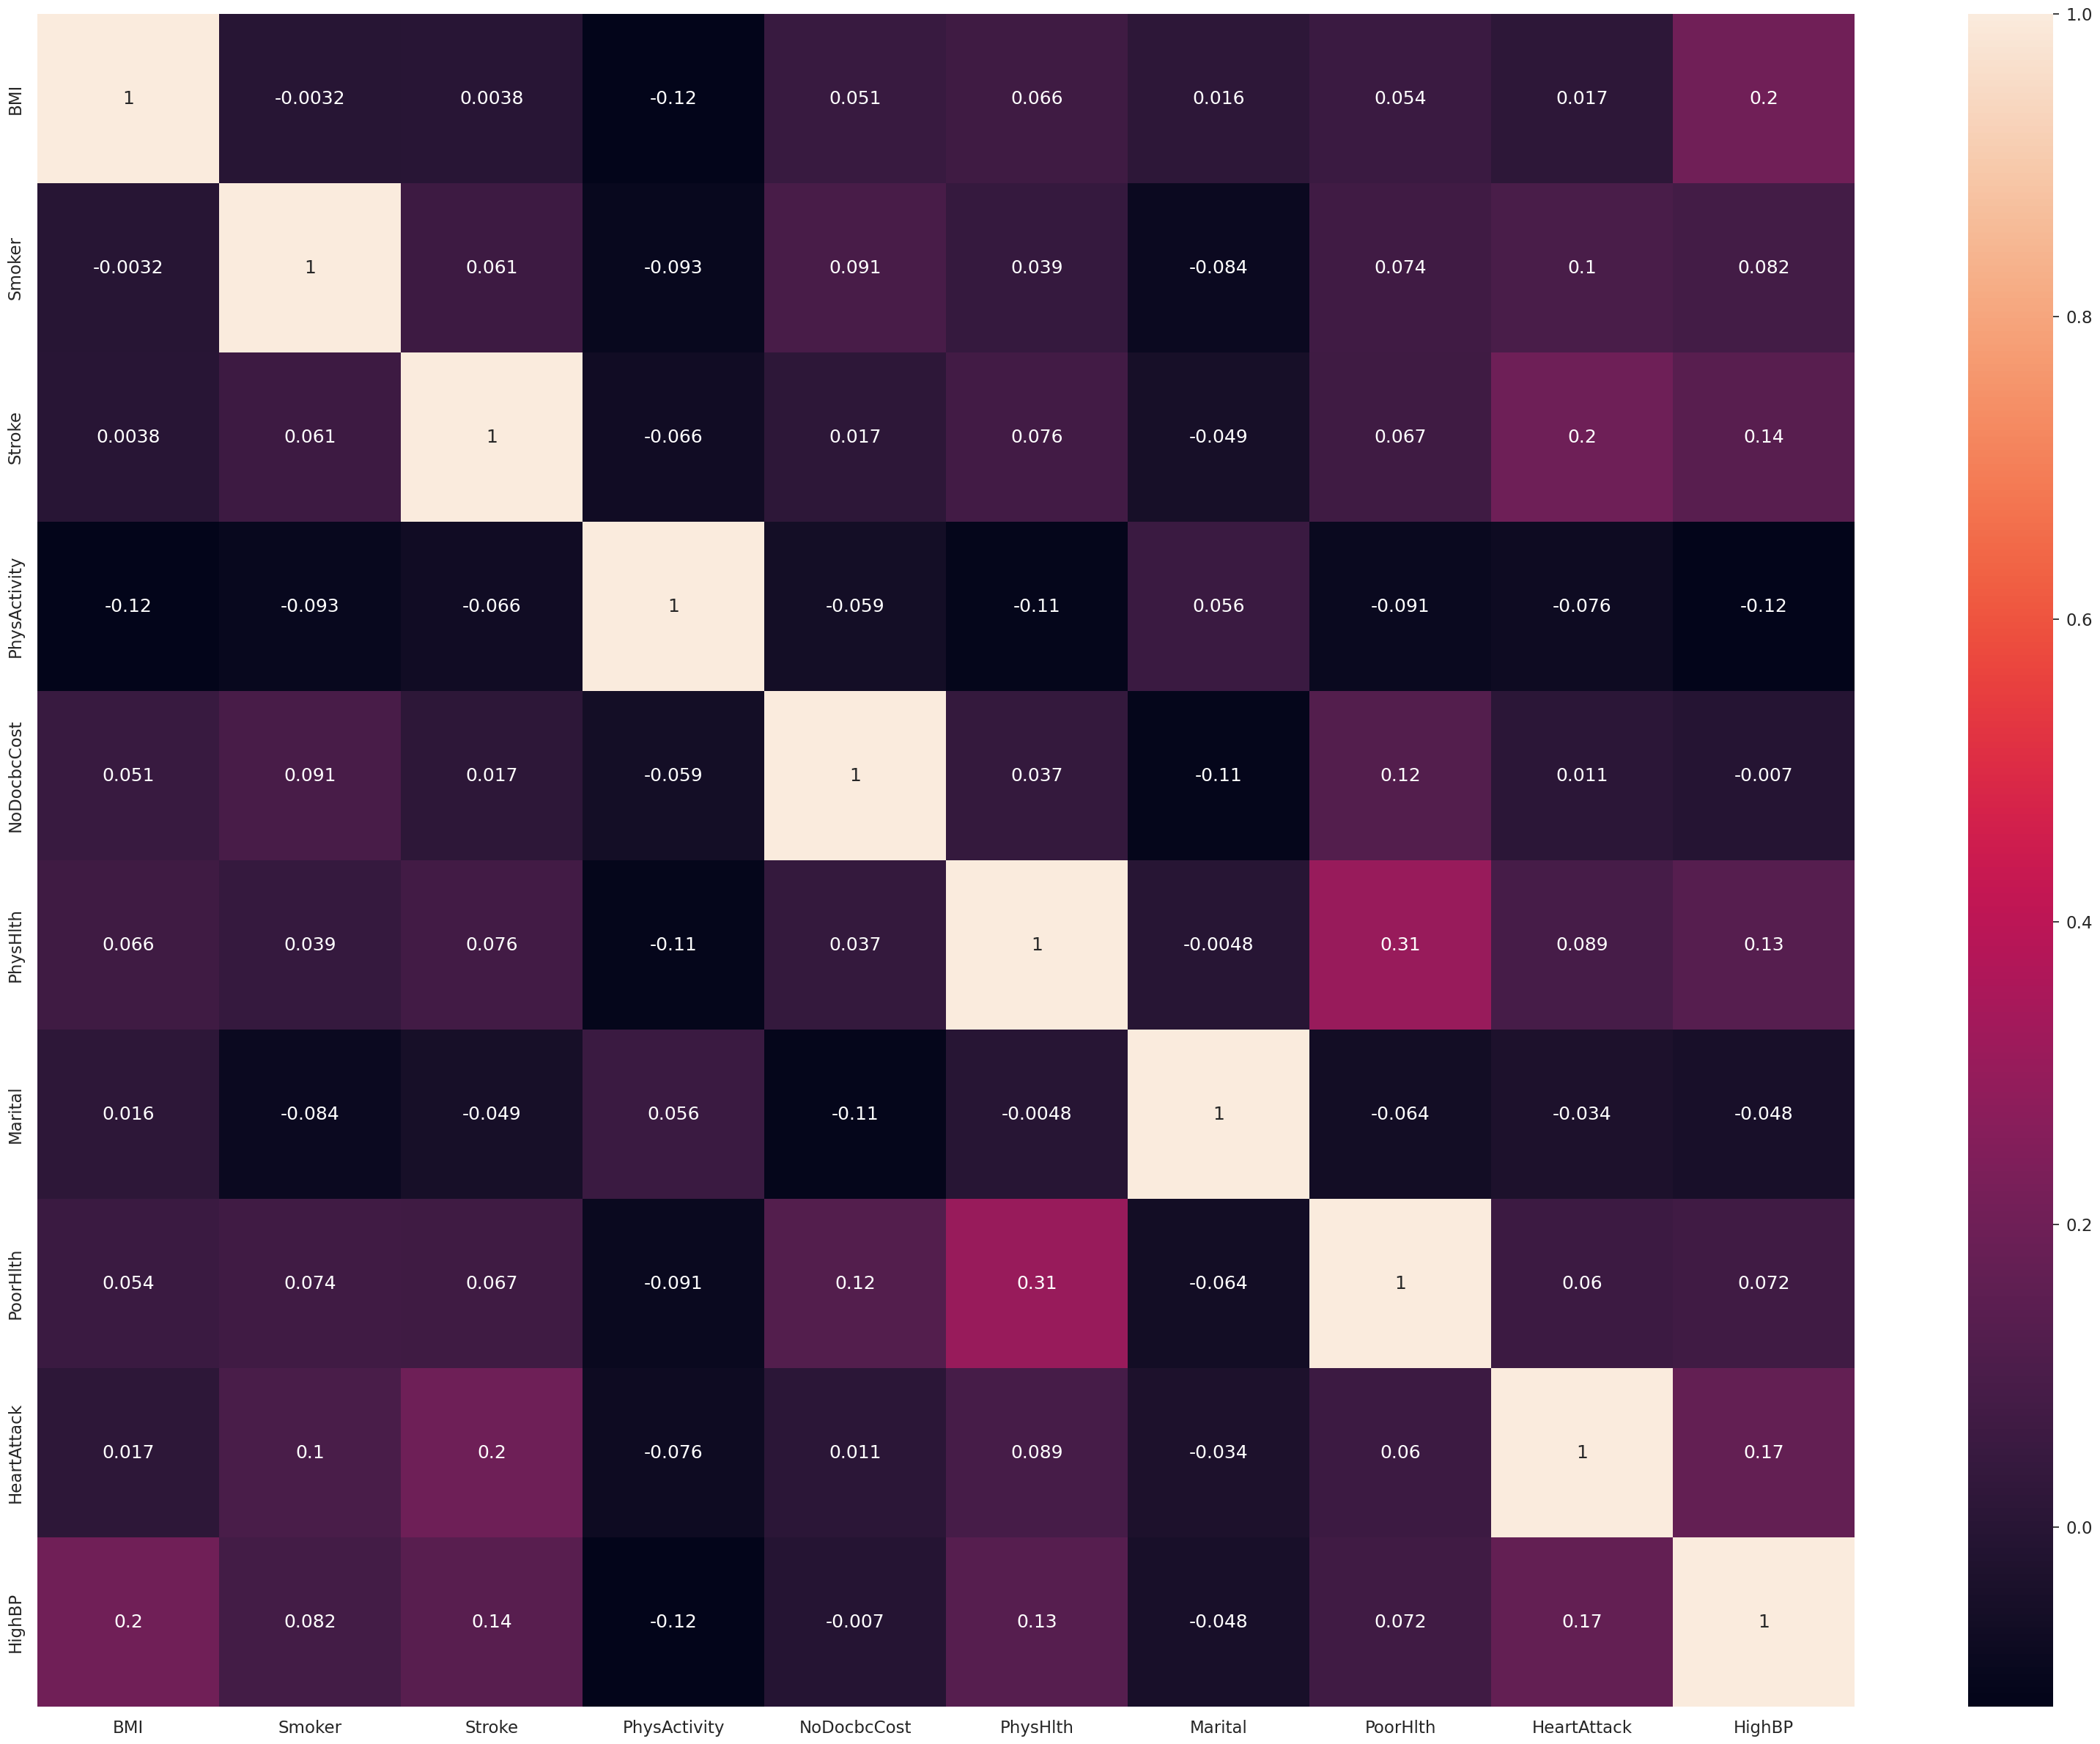

In [38]:
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are still features that are moderately correlated. We will eliminate one of the features for each correlated pair to reduce collinearity. 

## Create training and testing data sets

In [39]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)
print('Available Features',x.columns)
from sklearn.model_selection import train_test_split
x_tr_1, x_tst_1, y_tr_1, y_tst_1 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=0)

Available Features Index(['BMI', 'Smoker', 'Stroke', 'PhysActivity', 'NoDocbcCost', 'PhysHlth',
       'Marital', 'PoorHlth', 'HeartAttack', 'HighBP'],
      dtype='object')


## Initial Logistic Regression Models

### Statsmodels 

In [41]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
x_tr_1_const = add_constant(x_tr_1)
print(Logit(y_tr_1, x_tr_1_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.100589
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               337902
Model:                          Logit   Df Residuals:                   337891
Method:                           MLE   Df Model:                           10
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.04989
Time:                        20:22:12   Log-Likelihood:                -33989.
converged:                       True   LL-Null:                       -35774.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.1063      0.046   -111.373      0.000      -5.196      -5.016
BMI              0.3060

In [41]:
#x_tr_1_const = x_tr_1_const.drop(columns=['PhysActivity'])
#x_tr_1_const = x_tr_1_const.drop(columns=['Smoker'])

We can see that our model is doing an ok job, but could be improved. 
We will drop Physical Activity from the predictors, since it is not statistically significant.

In [42]:
x_tr_2, x_tst_2, y_tr_2, y_tst_2 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=1)
x_tr_2_const = add_constant(x_tr_2)
print(Logit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.100639
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               337902
Model:                          Logit   Df Residuals:                   337891
Method:                           MLE   Df Model:                           10
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.04942
Time:                        20:22:29   Log-Likelihood:                -34006.
converged:                       True   LL-Null:                       -35774.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.1194      0.046   -111.260      0.000      -5.210      -5.029
BMI              0.2975

In [45]:
print(Logit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.099497
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               337902
Model:                          Logit   Df Residuals:                   337891
Method:                           MLE   Df Model:                           10
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.06021
Time:                        04:02:41   Log-Likelihood:                -33620.
converged:                       True   LL-Null:                       -35774.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.5307      0.061    -90.740      0.000      -5.650      -5.411
BMI             0.3448    

In [43]:
y_new = data['Diabetes_012']
x_new = data.drop('Diabetes_012',axis=1)

In [44]:
x_tr_sk, x_tst_sk, y_tr_sk, y_tst_sk = train_test_split(x_new,y_new,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [47]:
from sklearn.linear_model import LogisticRegression
logit_2 = LogisticRegression(max_iter = 2500, class_weight='balanced',solver='newton-cg')
logit_2.fit(x_tr_sk,y_tr_sk)
y_pred_1 = logit_2.predict(x_tst_sk)
y_true_1 = y_tst_sk

Training accuracy:
0.66
Test accuracy:
0.66
Recall Score:
0.66
Precision Score:
0.97


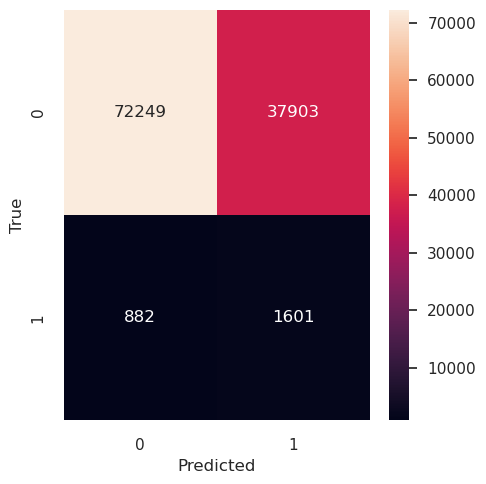

In [49]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Training accuracy:")
print(np.round(accuracy_score(y_tr_sk,logit_2.predict(x_tr_sk)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_true_1,y_pred_1),2))
print("Recall Score:")
print(np.round(recall_score(y_true_1, y_pred_1,average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(y_true_1, y_pred_1,average='weighted'),2))
from sklearn.metrics import confusion_matrix
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_true_1,y_pred_1)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


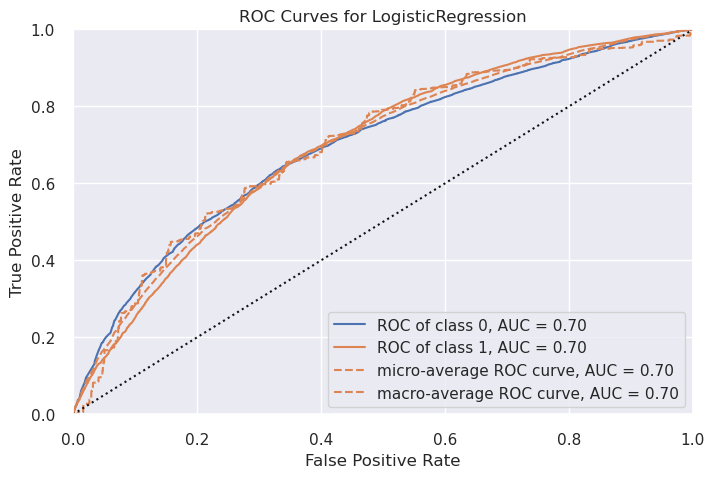

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
from yellowbrick.classifier import ROCAUC
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_2,classes=[0,1])
visualizer.fit(x_tr_sk, y_tr_sk)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

## RFE

In [52]:
from sklearn.feature_selection import RFE
x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
logit_rfe = LogisticRegression(max_iter=2500,solver='newton-cg',class_weight='balanced')
rfe = RFE(logit_rfe)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [53]:
col = x_rfe.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

0            BMI
2         Stroke
5       PhysHlth
8    HeartAttack
9         HighBP
Name: Columns, dtype: object

In [54]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [55]:
new_train_x_rfe_const = add_constant(new_train_x_rfe)
model = Logit(train_y_rfe, new_train_x_rfe_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.100889
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               337902
Model:                          Logit   Df Residuals:                   337896
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.04707
Time:                        20:26:08   Log-Likelihood:                -34090.
converged:                       True   LL-Null:                       -35774.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.2017      0.035   -146.808      0.000      -5.271      -5.132
BMI             0.3167    

In [57]:
logit_rfe_1 = LogisticRegression(max_iter = 2500,solver='newton-cg', class_weight='balanced')
logit_rfe_1.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = logit_rfe_1.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

coefficients = pd.concat([pd.DataFrame(new_train_x_rfe.columns),pd.DataFrame(np.transpose(logit_rfe_1.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.342937
1       Stroke  0.439215
2     PhysHlth  0.278319
3  HeartAttack  0.398384
4       HighBP  0.838004


Training accuracy:
0.65
Test accuracy:
0.65
Recall Score:
0.65
Precision Score:
0.97


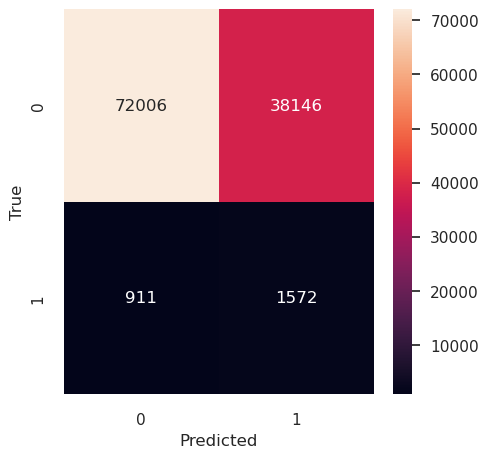

In [59]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,logit_rfe_1.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))
print("Recall Score:")
print(np.round(recall_score(test_y_rfe, y_pred_rfe,average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(test_y_rfe, y_pred_rfe,average='weighted'),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


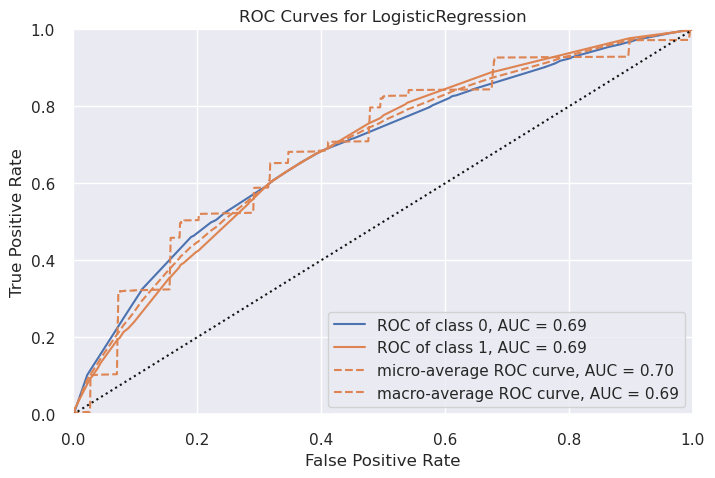

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [60]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_rfe_1,classes=[0,1])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

In [61]:
data = data[['Diabetes_012','BMI','Stroke','PoorHlth','HeartAttack','HighBP']]

## SMOTE

In [62]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)

x_tr, x_tst, y_tr, y_tst = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [63]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
counter = Counter(y_tr)
print(counter)
over = SMOTE(sampling_strategy={1:10000},random_state=12 )
#under = RandomUnderSampler(sampling_strategy={0: 6000,2:6000})
steps = [('o', over)]
#steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm ,trainY_sm = pipeline.fit_resample(x_tr, y_tr)

columns_x = x_tr.columns

train_x_smote = pd.DataFrame(data=trainX_sm,columns=columns_x)
train_y_smote = pd.DataFrame(data=trainY_sm,columns=['Diabetes_012'])

counter = Counter(trainY_sm)
print(counter)

Counter({0.0: 330455, 1.0: 7447})
Counter({0.0: 330455, 1.0: 10000})


In [64]:
logit_sm = LogisticRegression(solver='newton-cg',max_iter = 2500, class_weight='balanced' )
logit_sm.fit(train_x_smote, train_y_smote.values.ravel())

y_pr_sm = logit_sm.predict(x_tst)
coefficients = pd.concat([pd.DataFrame(train_x_smote.columns),pd.DataFrame(np.transpose(logit_sm.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.346838
1       Stroke  0.429124
2     PoorHlth  0.262495
3  HeartAttack  0.420747
4       HighBP  0.857405


Training accuracy:
0.64
Test accuracy:
0.64
Recall Score:
0.64
Precision Score:
0.97


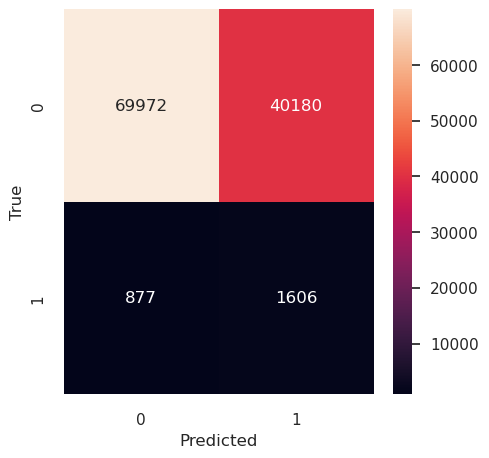

In [65]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst,y_pr_sm)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote,logit_sm.predict(train_x_smote)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst,y_pr_sm),2))
print("Recall Score:")
print(np.round(recall_score(y_tst, y_pr_sm, average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(y_tst, y_pr_sm, average='weighted'),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


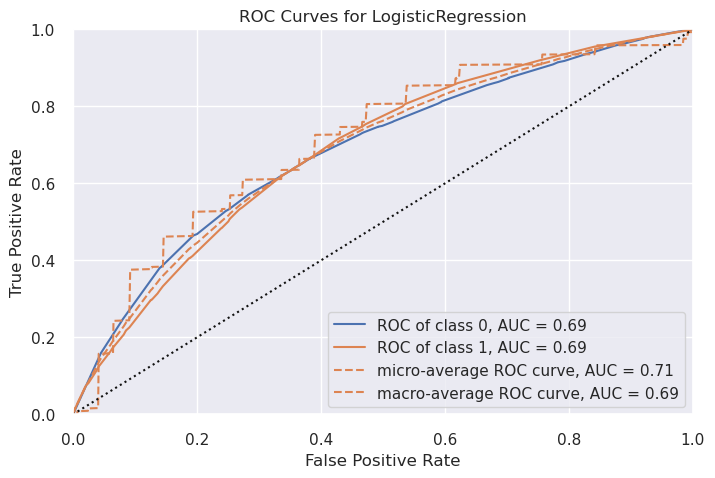

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_sm,classes=[0,1])
visualizer.fit(train_x_smote, train_y_smote)
visualizer.score(x_tst, y_tst)
visualizer.show() 

In [67]:
counter = Counter(y_tr)
print(counter)
over = SMOTE(sampling_strategy={1:10000},random_state=12 )
under = RandomUnderSampler(sampling_strategy={0: 100000})
#steps = [('o', over)]
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm_un,trainY_sm_un = pipeline.fit_resample(x_tr, y_tr)

columns_x = x_tr.columns

train_x_smote_under = pd.DataFrame(data=trainX_sm_un,columns=columns_x)
train_y_smote_under = pd.DataFrame(data=trainY_sm_un,columns=['Diabetes_012'])

counter = Counter(trainY_sm_un)
print(counter)

Counter({0.0: 330455, 1.0: 7447})
Counter({0.0: 100000, 1.0: 10000})


In [68]:
logit_sm_un = LogisticRegression(max_iter=2500,solver='newton-cg')
logit_sm_un.fit(train_x_smote_under, train_y_smote_under.values.ravel())

y_pr_sm_un = logit_sm_un.predict(x_tst)
coefficients = pd.concat([pd.DataFrame(train_x_smote_under.columns),pd.DataFrame(np.transpose(logit_sm_un.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.330588
1       Stroke  0.382597
2     PoorHlth  0.250409
3  HeartAttack  0.387421
4       HighBP  0.836870


Training accuracy:
0.91
Test accuracy:
0.98
Recall Score:
0.98
Precision Score:
0.96


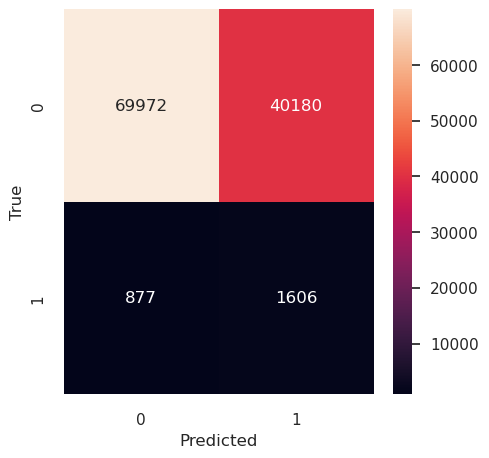

In [75]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst,y_pr_sm)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote_under,logit_sm_un.predict(train_x_smote_under)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst_sk,y_pr_sm_un),2))
print("Recall Score:")
print(np.round(recall_score(y_tst, y_pr_sm_un, average='weighted',zero_division=0),2))
print("Precision Score:")
print(np.round(precision_score(y_tst, y_pr_sm_un, average='weighted',zero_division=0),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


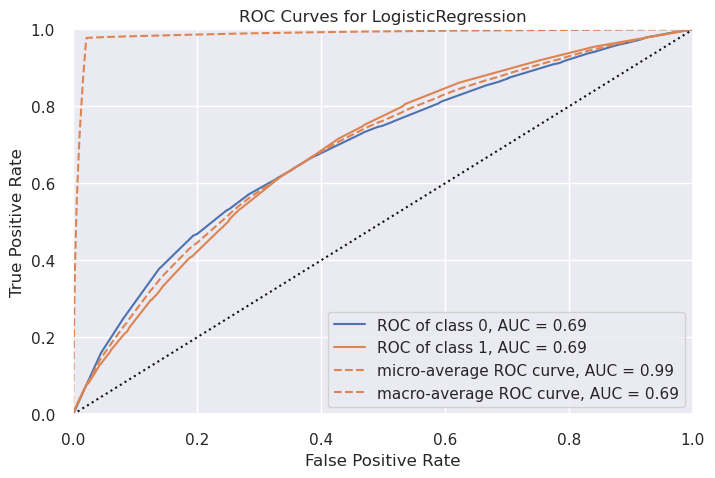

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [76]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_sm_un,classes=[0,1])
visualizer.fit(train_x_smote_under, train_y_smote_under)
visualizer.score(x_tst, y_tst) 
visualizer.show() 